In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import os
from pycbc.types import timeseries
from calcwf import *

In [2]:
sample_rate = 4096

# Plot functions

## Other functions

In [9]:
def favata_et_al_avg(given_e, given_chirp, e_vals, f_low=10, q=2):

    # Generate waveform at given point to use in sigmasq
    h = gen_wf(f_low, given_e, chirp2total(given_chirp, q), q, 4096, 'TEOBResumS')
    h.resize(ceiltwo(len(h)))
    
    # Generate the aLIGO ZDHP PSD
    psd, _ = gen_psd(h, f_low)

    # Calculate both integrals using sigmasq
    h = h.real().to_frequencyseries()
    ss = sigmasq(h, psd=psd, low_frequency_cutoff=f_low+3)
    ssf = sigmasq(h*h.sample_frequencies**(-7/3), psd=psd, low_frequency_cutoff=f_low+3)

    # Use average frequency to evolve eccentricities
    avg_f = (ssf/ss)**(-3/14)
    print('Average frequency: '+str(avg_f)+' Hz')
    s_given_e = shifted_e(avg_f, f_low, given_e)
    print(f'Given_e shifted from {given_e} to {s_given_e}')
    s_e_vals = shifted_e(avg_f, f_low, e_vals)

    # Find effective chirp mass of given point
    eff_chirp = given_chirp/(1-(157/24)*s_given_e**2)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp*(1-(157/24)*s_e_vals**2)**(3/5)

    return chirp_vals

In [10]:
def quad_sine_model(x, coeff_array):

    quad_total = 0
    for coeff_list in coeff_array:
        quad_total += (coeff_list[0]*np.sin(x+coeff_list[1])+coeff_list[2])**2

    return np.sqrt(quad_total)

## Target TA functions

In [11]:
def zero_TA(wf_hjs, n, fid_e, fid_M, q, f_low, approximant):
    return 0

In [12]:
def half_pi_TA(wf_hjs, n, fid_e, fid_M, q, f_low, approximant):
    return np.pi/2

In [13]:
def get_TA_sine(wf_hjs, n, fid_e, fid_M, q, f_low, approximant):

    # Generate each TEOBResumS waveform and calculate matches
    sine_e = fid_e*1.1
    sine_chirp = favata_et_al_avg(fid_e, fid_M, sine_e, f_low, q)
    sine_s_f_max = f_low - shifted_f(f_low, sine_e, chirp2total(sine_chirp, q), q)
    sine_s_f_vals = np.linspace(f_low, f_low - 0.5*sine_s_f_max, 3)
    sine_s_e_vals = shifted_e(sine_s_f_vals, f_low, sine_e)
    mn_cplxs = []
    for sine_s_f, sine_s_e in zip(sine_s_f_vals, sine_s_e_vals):
        sine_wf = gen_wf(sine_s_f, sine_s_e, chirp2total(sine_chirp, q), q, sample_rate, approximant=approximant)
        mn_cplxs.append(match_hn(wf_hjs, sine_wf, f_low))

    # Calculate sine coeffs
    coeffs = []
    mn_cplxs = np.array(mn_cplxs).T
    for mn_cplx in mn_cplxs:
        coeffs.append(sine_model_coeffs(*np.abs(mn_cplx)))
    
    # Use location of peak of first sinusoid for initial guess
    init_guess = np.pi/2 - coeffs[0][1]
    if init_guess > 0:
        init_guess -= 2*np.pi

    # Set bounds and arguments of function
    args = ([np.array(coeffs)])
    bounds = [(-2*np.pi, 0)]

    # Perform maximisation
    max_result = minimize(lambda x: -quad_sine_model(x, *args), init_guess, bounds=bounds)
    max_location = max_result['x']

    # Calculate shift required by subtracting phase difference
    phase_diff = np.angle(mn_cplxs[1][0]) - np.angle(mn_cplxs[0][0])
    target_TA = max_location - phase_diff
    if target_TA > 0:
        target_TA -= 2*np.pi
    elif target_TA <= -2*np.pi:
        target_TA += 2*np.pi
    print(target_TA)

    return target_TA

## Calculate match functions

In [14]:
def no_maximisation(s, wf_hjs, e, chirp, n, fid_e, fid_M, q, f_low, approximant, target_TA):
    match_cplx = match_hn(wf_hjs, s, f_low)
    return match_cplx

In [15]:
def shift_h(s, wf_hjs, e, chirp, n, fid_e, fid_M, q, f_low, approximant, target_TA):

    # Calculate phase difference from initial match
    match_cplx = match_hn(wf_hjs, s, f_low)
    phase_diff = np.angle(match_cplx[1])-np.angle(match_cplx[0])+target_TA
    if phase_diff > 0:
        phase_diff -= 2*np.pi
    elif phase_diff < -2*np.pi:
        phase_diff += 2*np.pi

    # Shift f and e by phase difference
    s_f_range = f_low - shifted_f(f_low, e, chirp2total(chirp, q), q)
    s_f = f_low + (phase_diff/(2*np.pi))*s_f_range
    s_e = shifted_e(s_f, f_low, e)

    # Recalculate match
    wf_s_f = gen_wf(s_f, s_e, chirp2total(chirp, q), q, sample_rate, approximant)
    match_cplx = match_hn(wf_hjs, wf_s_f, f_low)
    
    return match_cplx

In [16]:
def shift_hn(s, wf_hjs, e, chirp, n, fid_e, fid_M, q, f_low, approximant, target_TA):

    # Calculate phase difference from initial match
    match_cplx = match_hn(wf_hjs, s, f_low)
    phase_diff = np.angle(match_cplx[0])-np.angle(match_cplx[1])+target_TA
    if phase_diff > 0:
        phase_diff -= 2*np.pi
    elif phase_diff < -2*np.pi:
        phase_diff += 2*np.pi

    # Shift f and e by phase difference
    s_f_range = f_low - shifted_f(f_low, fid_e, chirp2total(fid_M, q), q)
    s_f = f_low + (phase_diff/(2*np.pi))*s_f_range
    s_e = shifted_e(s_f, f_low, fid_e)

    # Recalculate match
    all_wfs = list(get_h([1]*n, s_f, s_e, chirp2total(fid_M, q), q, sample_rate, approximant=approximant))
    match_cplx = match_hn(all_wfs[1:n+1], s, f_low)
    
    return match_cplx

## General functions

In [17]:
def chirp_match_data(param_vals, n, fid_e, fid_M, q, f_low, approximant='TEOBResumS', TA_method=zero_TA, match_method=no_maximisation, param='chirp', fixed_e=None):

     # Setup match dict and calculate conversion from chirp to total mass
    matches = {'diff_phase':[], 'quad':[]}
    for i in range(n):
            matches[f'h{i+1}'] = []
            matches[f'h{i+1}_phase'] = []

    # Generate fiducial waveform
    all_wfs = list(get_h([1]*n, f_low, fid_e, chirp2total(fid_M, q), q, sample_rate, approximant=approximant))
    wf_hjs = all_wfs[1:n+1]

    # Generate param values
    if param=='chirp':
        if fixed_e is None:
            fixed_e = fid_e
        e_vals = np.full(len(param_vals), fixed_e)
        chirp_vals = param_vals
    elif param=='ecc_chirp':
        e_vals = param_vals
        chirp_vals = favata_et_al_avg(fid_e, fid_M, e_vals, f_low=f_low, q=q)

    # TA to shift to
    target_TA = TA_method(wf_hjs, n, fid_e, fid_M, q, f_low, approximant)

    # Progress bar setup
    progress = 0
    gridsize = len(chirp_vals)
    
    # Loop over chirp mass values
    for e, chirp in zip(e_vals, chirp_vals):
        s = gen_wf(f_low, e, chirp2total(chirp, q), q, sample_rate, approximant=approximant)

        # Calculate matches with chosen method
        match_cplx = match_method(s, wf_hjs, e, chirp, n, fid_e, fid_M, q, f_low, approximant, target_TA)

        # Save matches
        match_quad_sqrd = 0
        for i in range(n):
            matches[f'h{i+1}'].append(abs(match_cplx[i]))
            matches[f'h{i+1}_phase'].append(np.angle(match_cplx[i]))
            match_quad_sqrd += abs(match_cplx[i])**2
        phase_diff = np.angle(match_cplx[1])-np.angle(match_cplx[0])+target_TA
        if phase_diff > 0:
            phase_diff -= 2*np.pi
        elif phase_diff < -2*np.pi:
            phase_diff += 2*np.pi
        matches['diff_phase'].append(phase_diff)
        matches['quad'].append(np.sqrt(match_quad_sqrd))

        # Progress bar
        progress += 1
        print('\r' + f'{progress} done out of {gridsize}', end='')

    return matches

In [18]:
# Plots match contours on eccentricity/chirp mass plot
def chirp_match_plot(param_vals, n, fid_e, fid_M, q, matches, labels, param='chirp', fixed_e=None):

    # Fixed parameter settings
    if fixed_e is None:
        fixed_e = fid_e
    fixed_dict = {'chirp': 'ecc', 'ecc_chirp': 'ecc chirp'}
    fixed = fixed_dict[param]
    truth_dict = {'chirp': fid_M, 'ecc_chirp': fid_e}
    truth = truth_dict[param]
    xlabel_dict = {'chirp': '$\mathcal{M}~/~M_\odot$', 'ecc_chirp': 'e'}
    xlabel = xlabel_dict[param]

    # Make contour plot for  each match
    keys = [f'h{i+1}' for i in range(n)]
    keys.append('quad')
    for i, key in enumerate(keys):

        # Plotting amplitude of matches against chirp mass
        for match, label in zip(matches, labels):
            plt.plot(param_vals, match[key], label=label)
        plt.axvline(truth, c='k', ls='dashed', zorder=5, alpha=0.7)
        ylim = plt.gca().get_ylim()
        plt.axhline(1, c='k', ls='dashed', zorder=5, alpha=0.7)
        plt.ylim(ylim)
        plt.xlabel(xlabel)
        plt.ylabel('match')
        plt.title(f'{key}, q={q}, fixed {fixed}')
        plt.legend()
        plt.xlim(param_vals[0], param_vals[-1])
        plt.show()

    # Plotting amplitude of matches against chirp mass
    for match, label in zip(matches, labels):
        plt.plot(param_vals, np.array(match['h2'])/np.array(match['h1']), label=label)
    plt.axvline(truth, c='k', ls='dashed', zorder=5, alpha=0.7)
    ylim = plt.gca().get_ylim()
    plt.axhline(1, c='k', ls='dashed', zorder=5, alpha=0.7)
    plt.ylim(ylim)
    plt.xlabel(xlabel)
    plt.ylabel('match')
    plt.title(f'h2/h1, q={q}, fixed {fixed}')
    plt.legend()
    plt.xlim(param_vals[0], param_vals[-1])
    plt.show()

## Save/Load data

In [19]:
# Save data as pickle
def save_dataslot(data, no):
    with open(os.path.join('match_vs_chirp_data', f'dataslot_{no}'), 'wb') as fp:
        pickle.dump(data, fp)

# Load data as pickle
def load_dataslot(no):
    with open(os.path.join('match_vs_chirp_data', f'dataslot_{no}'), 'rb') as fp:
        data = pickle.load(fp)
    return data

# Plots

## n=2, no maximisation, against chirp

In [14]:
# start = time.time()
# dataslot_0 = chirp_match_data(np.linspace(23,25,101), 2, 0.1, 24, 2, 10)
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_0, 0)

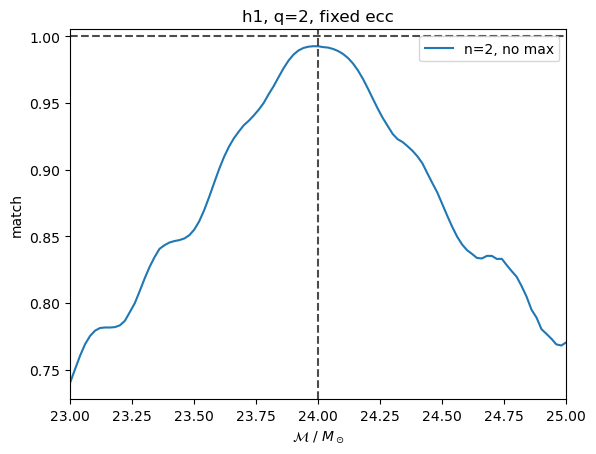

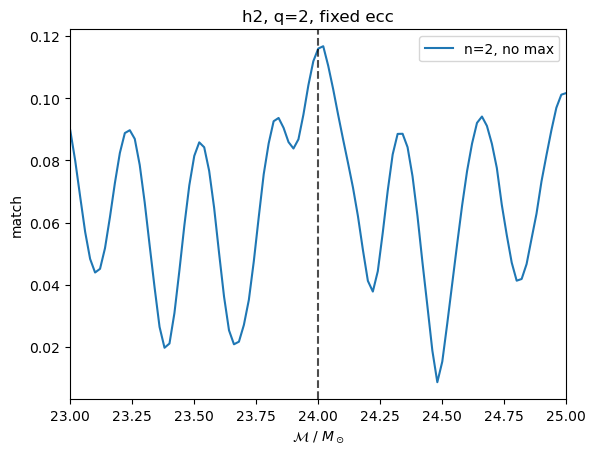

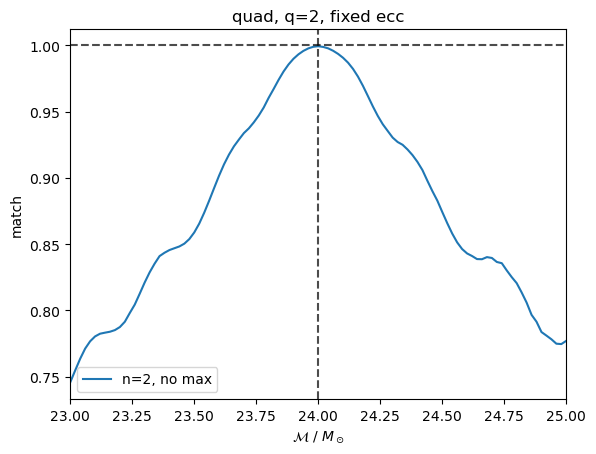

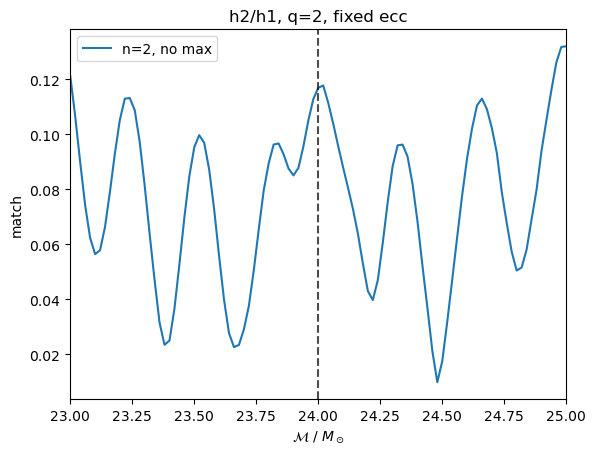

In [15]:
dataslot_0 = load_dataslot(0)
chirp_match_plot(np.linspace(23,25,101), 2, 0.1, 24, 2, [dataslot_0], ['n=2, no max'])

## n=4, no maximisation, against chirp

In [16]:
# start = time.time()
# dataslot_1 = chirp_match_data(np.linspace(23,25,101), 4, 0.1, 24, 2, 10)
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_1, 1)

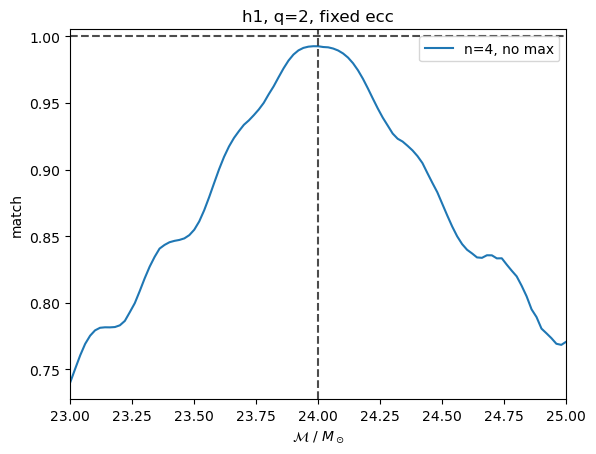

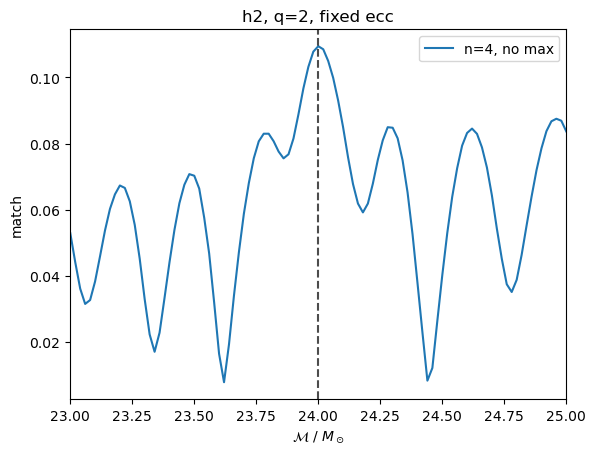

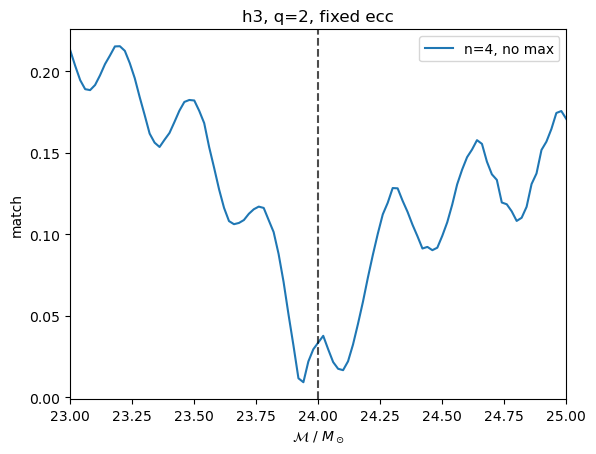

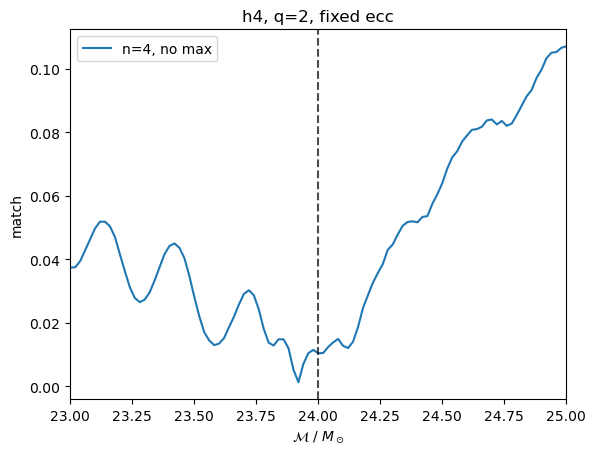

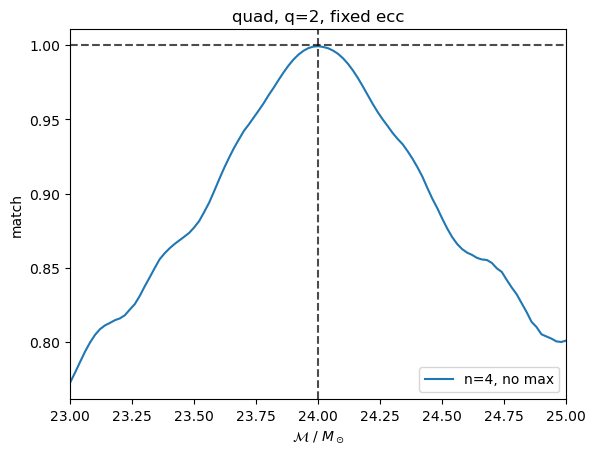

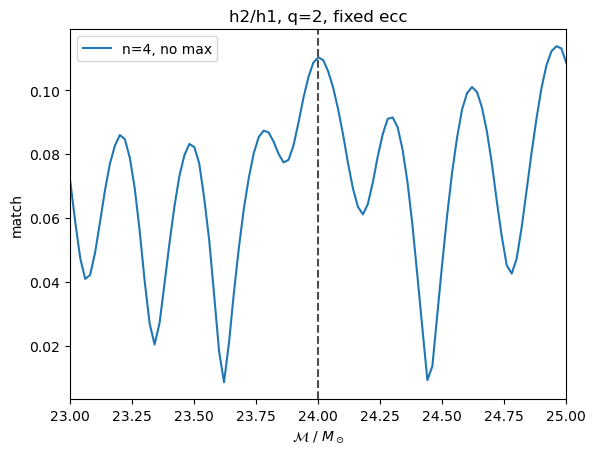

In [17]:
dataslot_1 = load_dataslot(1)
chirp_match_plot(np.linspace(23,25,101), 4, 0.1, 24, 2, [dataslot_1], ['n=4, no max'])

## n=4, no maximisation, against chirp, zero ecc

In [17]:
# start = time.time()
# dataslot_24 = chirp_match_data(np.linspace(23,25,101), 4, 0, 24, 2, 10)
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_24, 24)

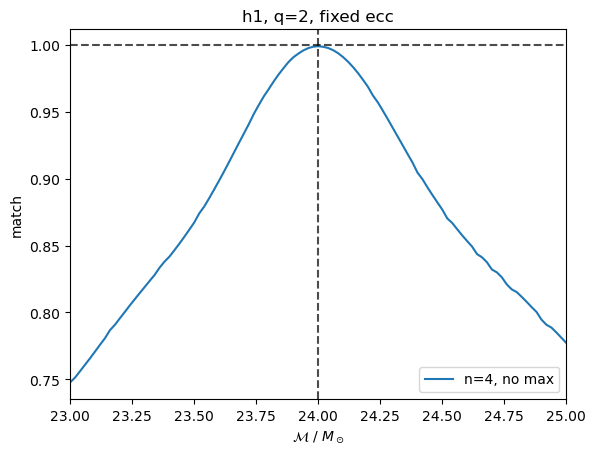

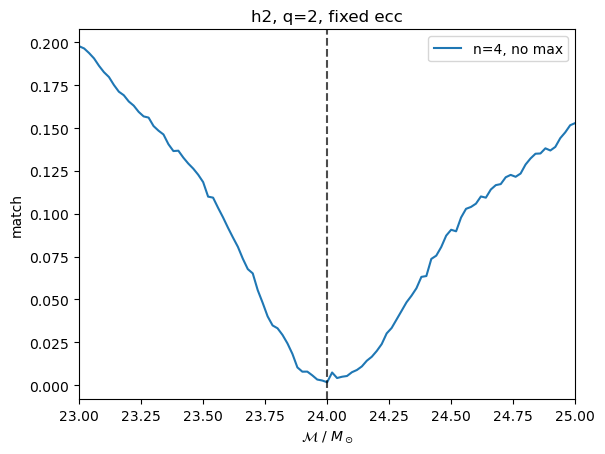

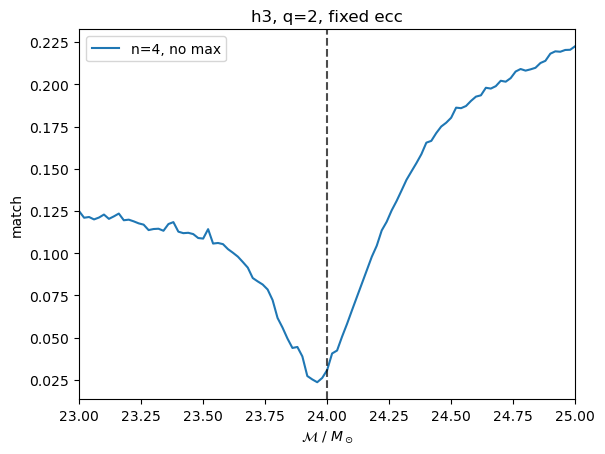

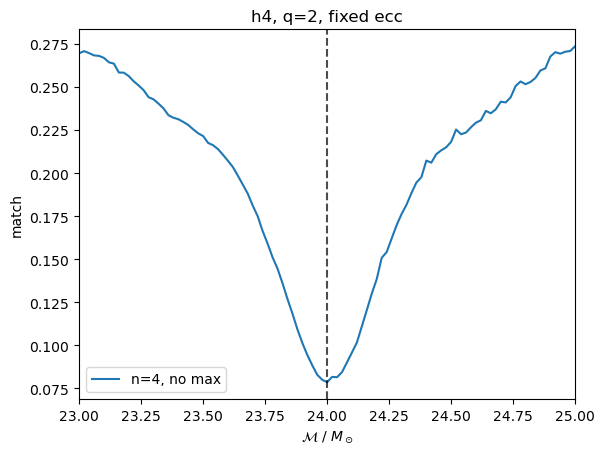

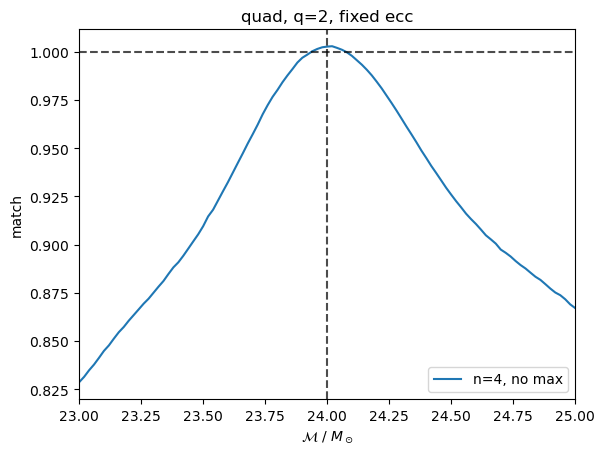

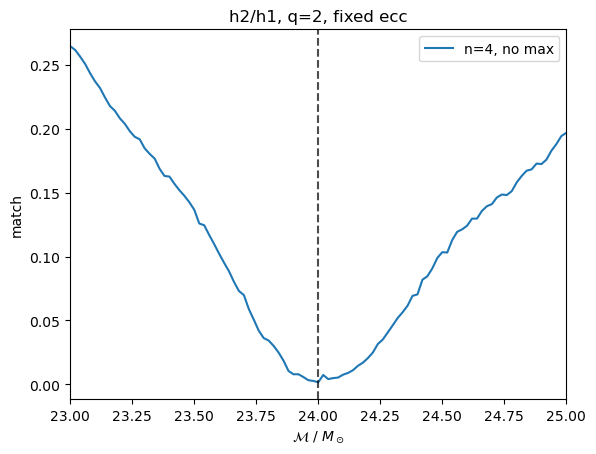

In [16]:
dataslot_24 = load_dataslot(24)
chirp_match_plot(np.linspace(23,25,101), 4, 0, 24, 2, [dataslot_24], ['n=4, no max'])

## n=2, phase difference, shift h, against chirp

In [18]:
# start = time.time()
# dataslot_2 = chirp_match_data(np.linspace(23,25,101), 2, 0.1, 24, 2, 10, match_method=shift_h)
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_2, 2)

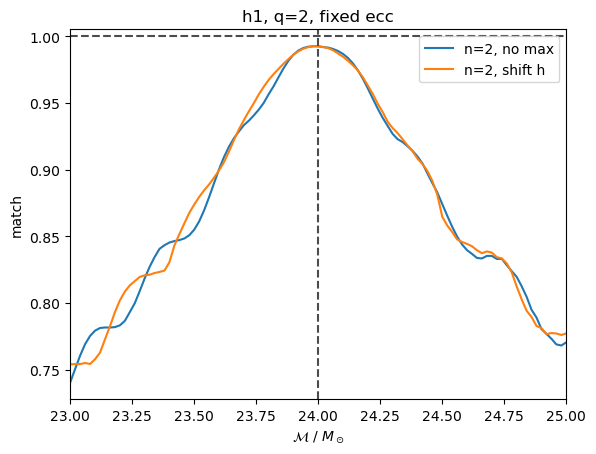

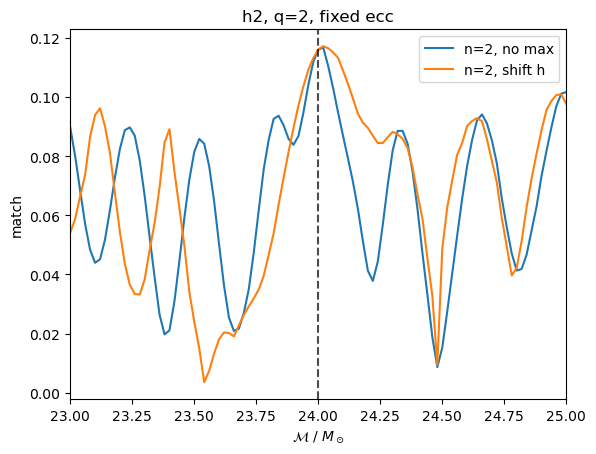

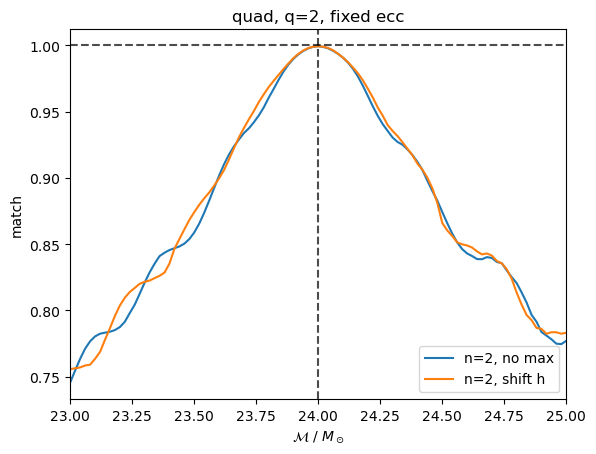

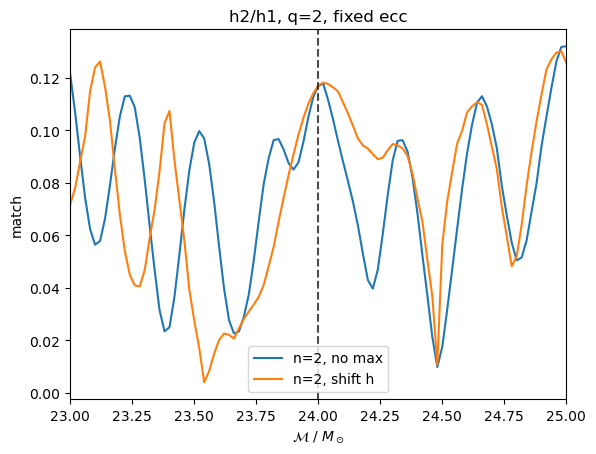

In [19]:
dataslot_2 = load_dataslot(2)
chirp_match_plot(np.linspace(23,25,101), 2, 0.1, 24, 2, [dataslot_0, dataslot_2], ['n=2, no max', 'n=2, shift h'])

## n=4, phase difference, shift h, against chirp

In [20]:
# start = time.time()
# dataslot_3 = chirp_match_data(np.linspace(23,25,101), 4, 0.1, 24, 2, 10, match_method=shift_h)
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_3, 3)

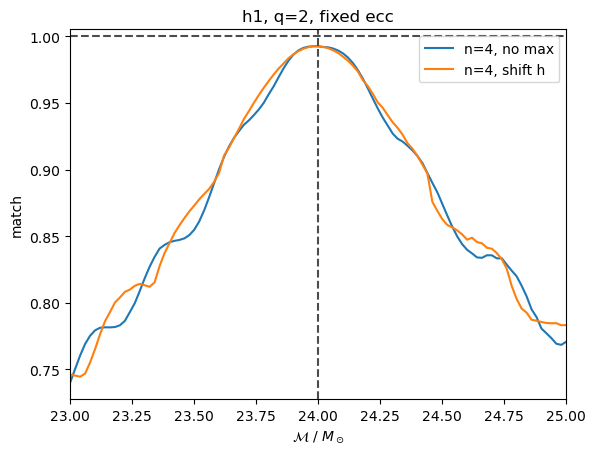

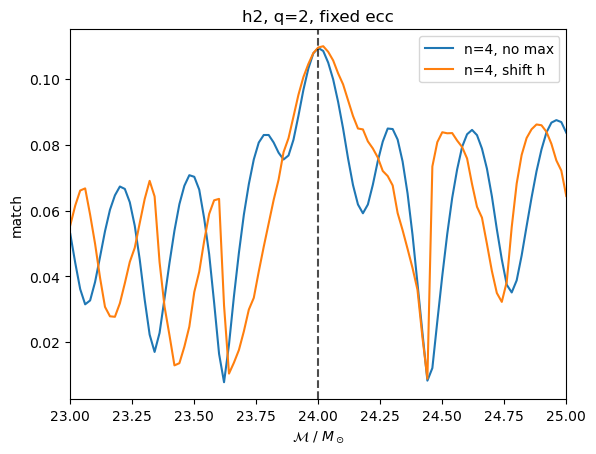

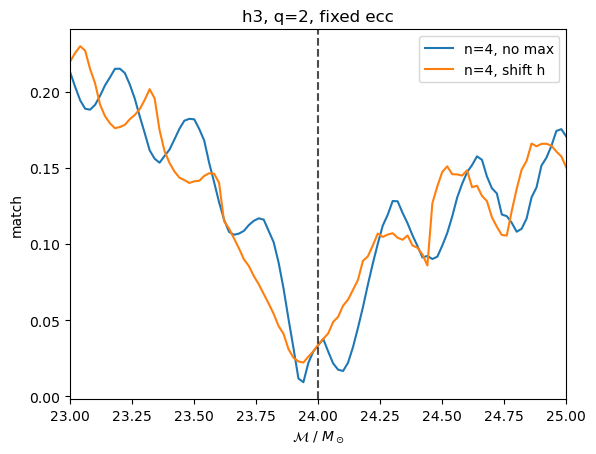

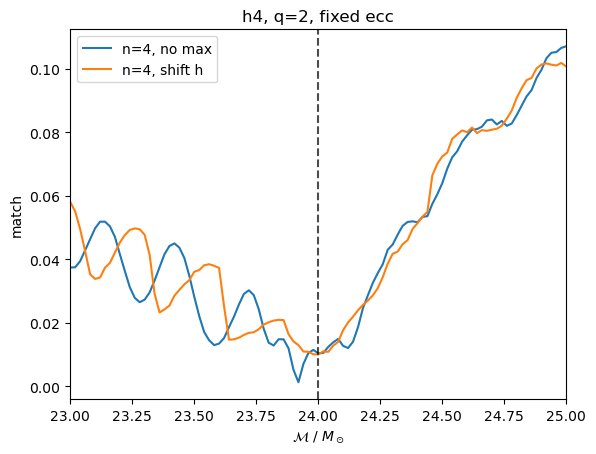

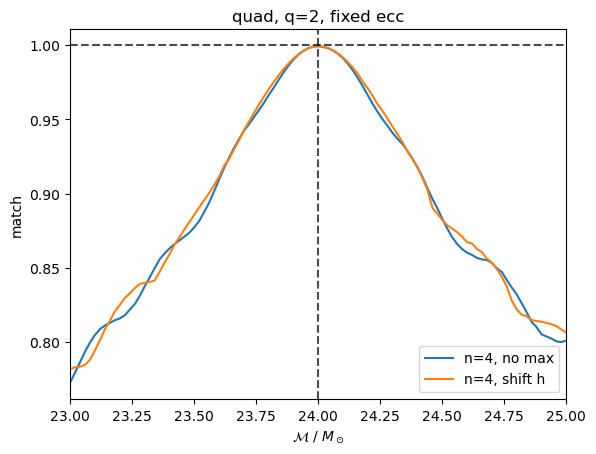

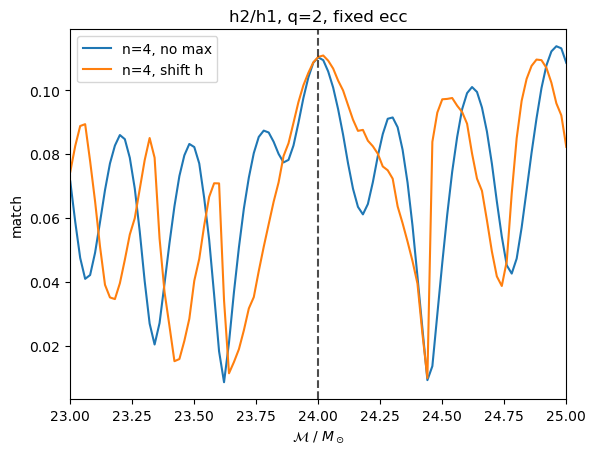

In [21]:
dataslot_3 = load_dataslot(3)
chirp_match_plot(np.linspace(23,25,101), 4, 0.1, 24, 2, [dataslot_1, dataslot_3], ['n=4, no max', 'n=4, shift h'])

## n=2, no maximisation, against ecc chirp

In [22]:
# start = time.time()
# dataslot_4 = chirp_match_data(np.linspace(0,0.2,101), 2, 0.1, 24, 2, 10, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_4, 4)

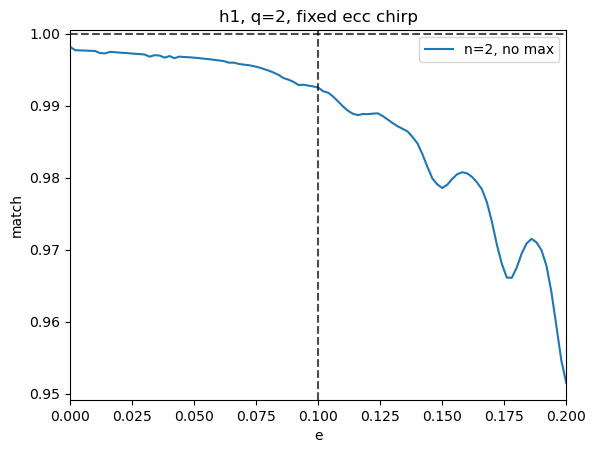

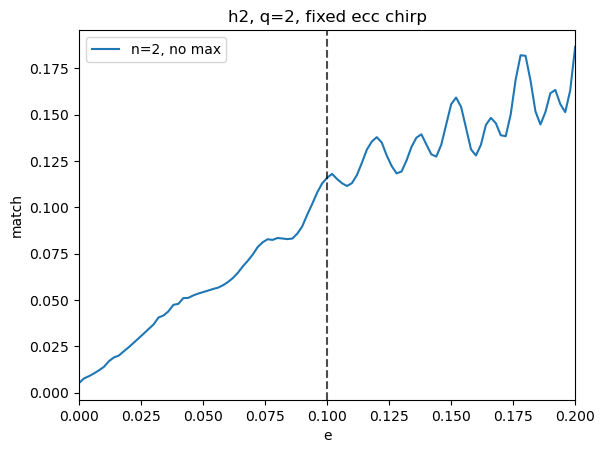

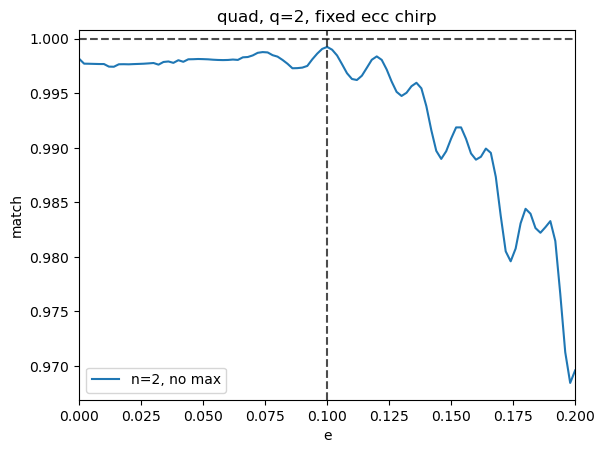

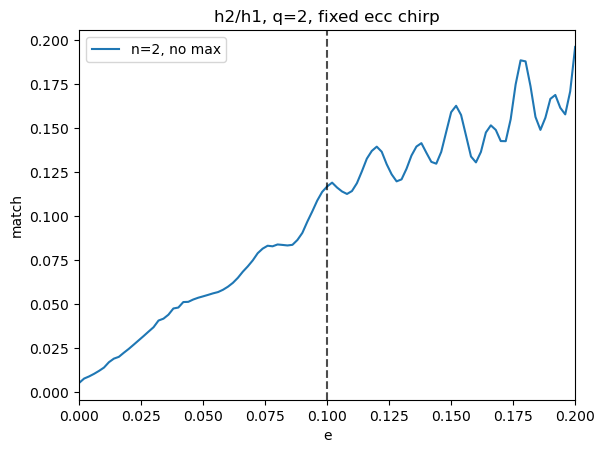

In [23]:
dataslot_4 = load_dataslot(4)
chirp_match_plot(np.linspace(0,0.2,101), 2, 0.1, 24, 2, [dataslot_4], ['n=2, no max'], param='ecc_chirp')

## n=4, no maximisation, against ecc chirp

In [24]:
# start = time.time()
# dataslot_5 = chirp_match_data(np.linspace(0,0.2,101), 4, 0.1, 24, 2, 10, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_5, 5)

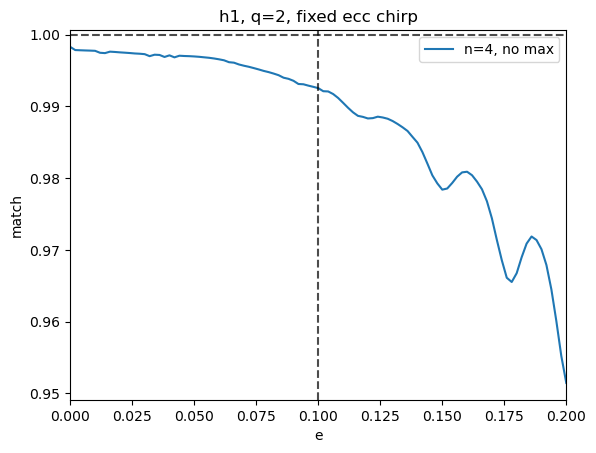

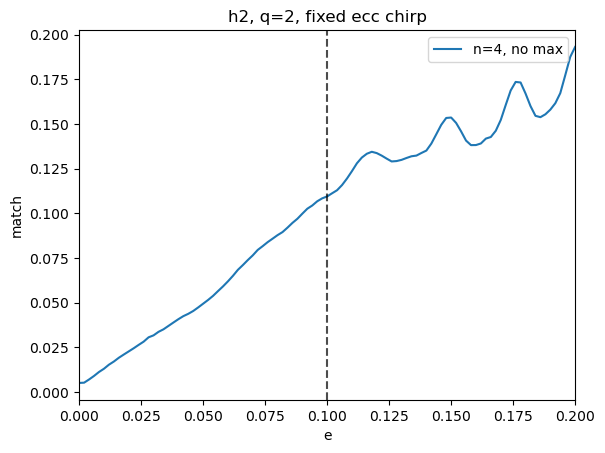

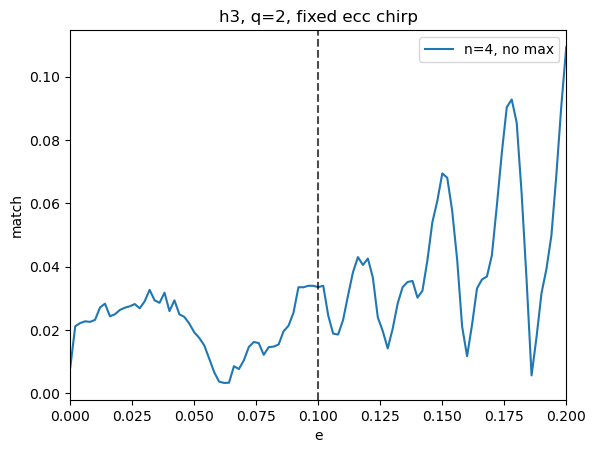

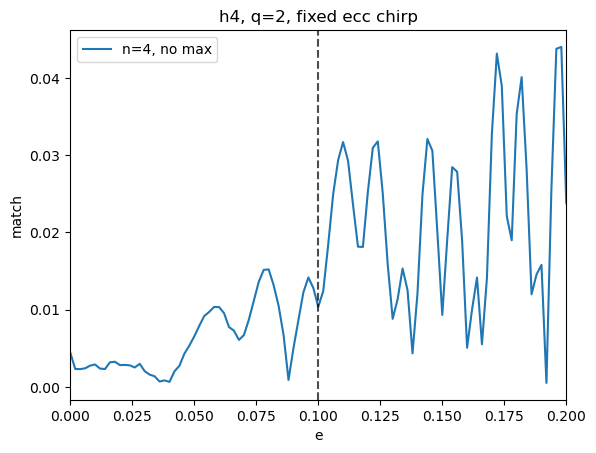

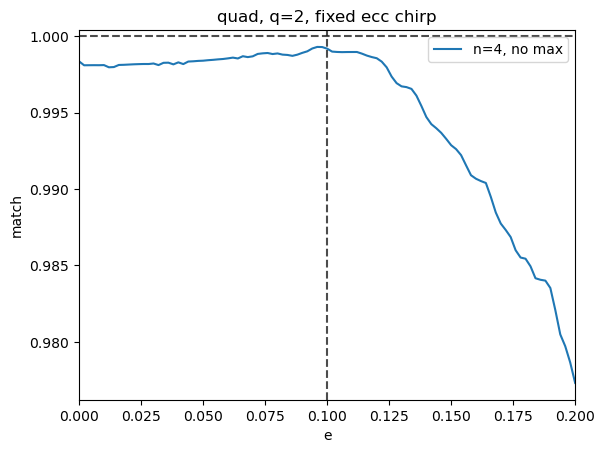

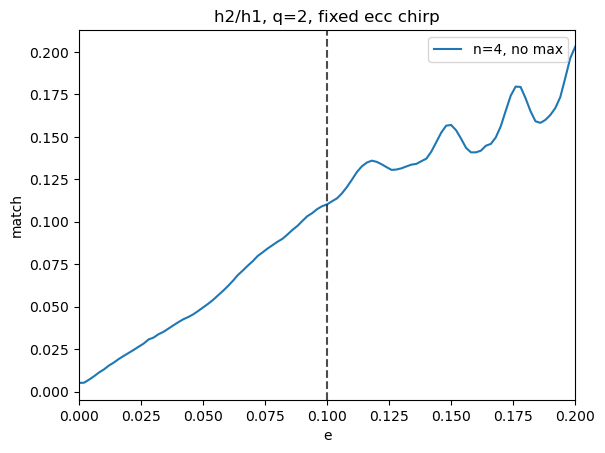

In [25]:
dataslot_5 = load_dataslot(5)
chirp_match_plot(np.linspace(0,0.2,101), 4, 0.1, 24, 2, [dataslot_5], ['n=4, no max'], param='ecc_chirp')

## n=2, phase difference, shift h, against ecc chirp

In [26]:
# start = time.time()
# dataslot_6 = chirp_match_data(np.linspace(0,0.2,101), 2, 0.1, 24, 2, 10, match_method=shift_h, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_6, 6)

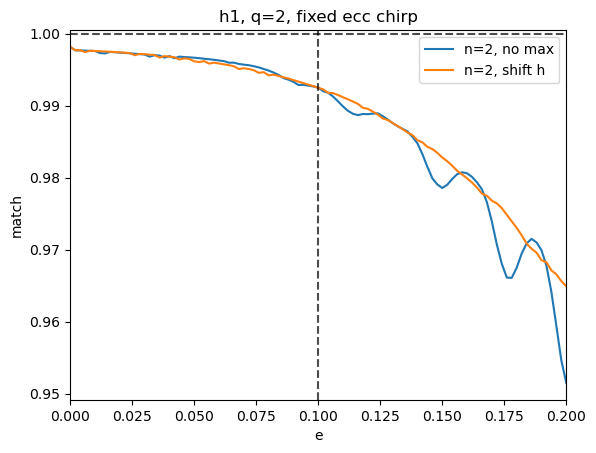

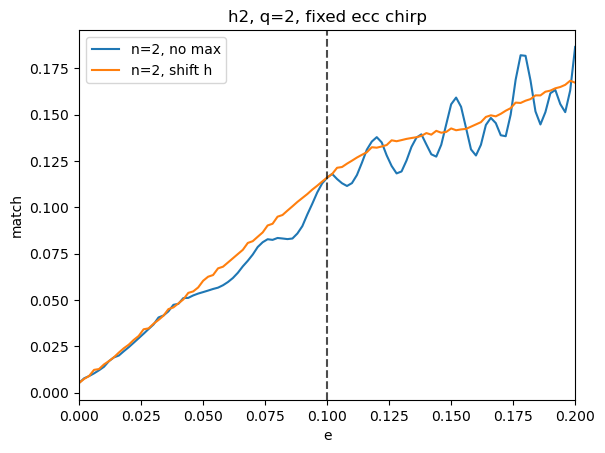

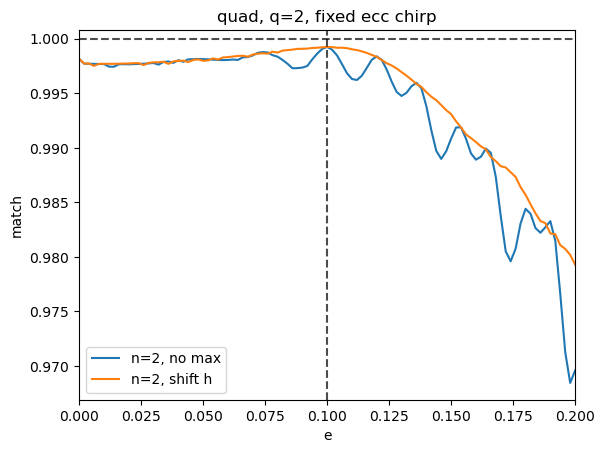

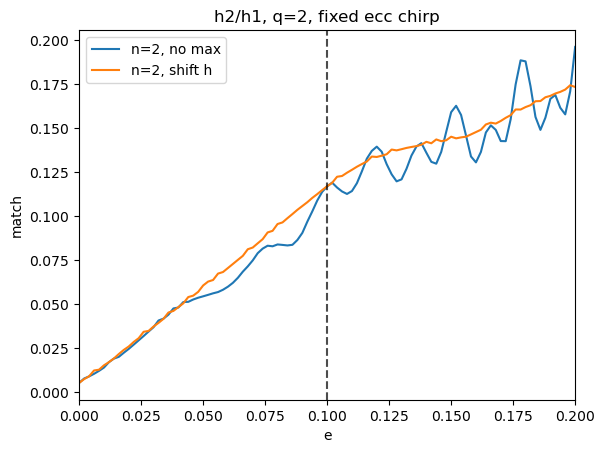

In [27]:
dataslot_6 = load_dataslot(6)
chirp_match_plot(np.linspace(0,0.2,101), 2, 0.1, 24, 2, [dataslot_4, dataslot_6], ['n=2, no max', 'n=2, shift h'], param='ecc_chirp')

## n=4, phase difference, shift h, against ecc chirp

In [28]:
# start = time.time()
# dataslot_7 = chirp_match_data(np.linspace(0,0.2,101), 4, 0.1, 24, 2, 10, match_method=shift_h, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_7, 7)

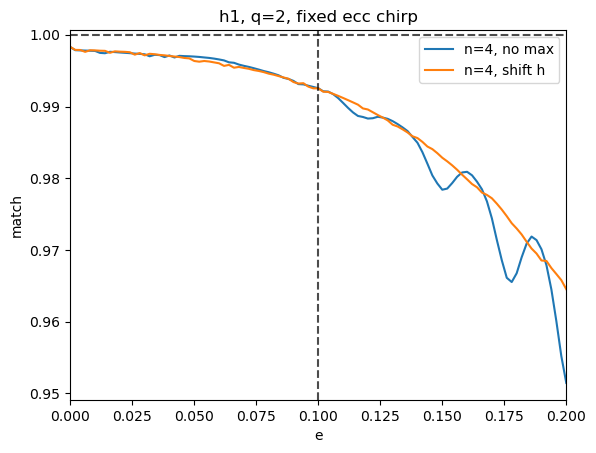

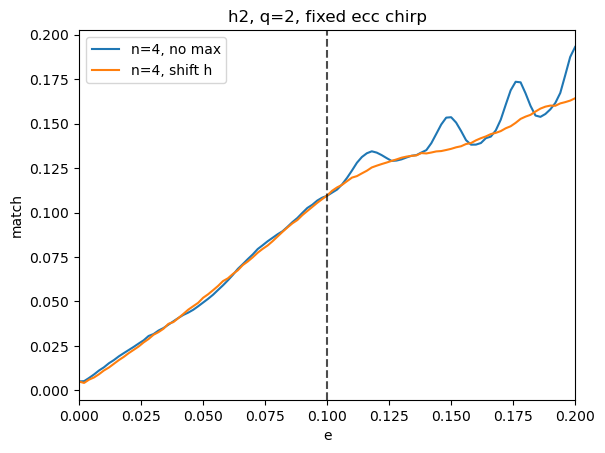

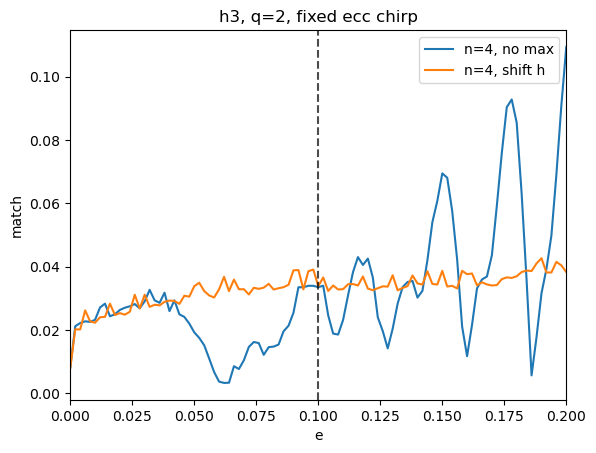

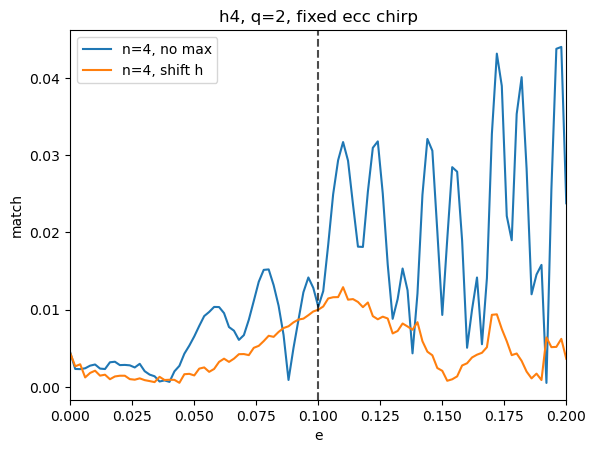

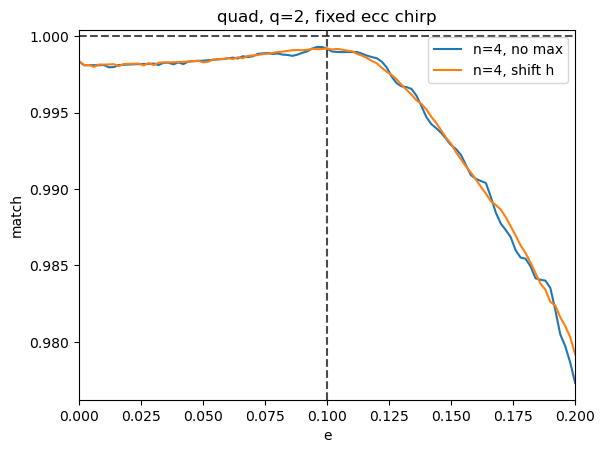

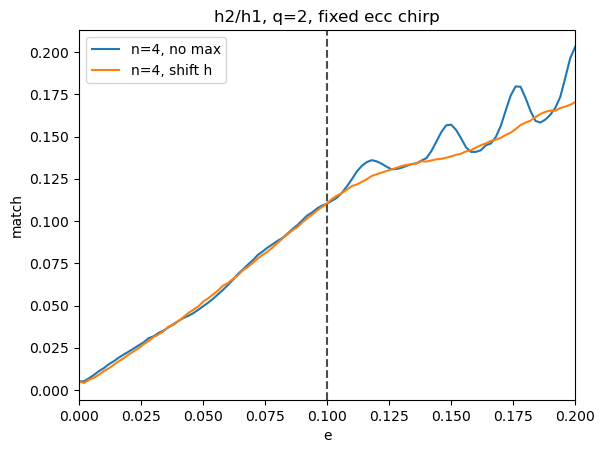

In [29]:
dataslot_7 = load_dataslot(7)
chirp_match_plot(np.linspace(0,0.2,101), 4, 0.1, 24, 2, [dataslot_5, dataslot_7], ['n=4, no max', 'n=4, shift h'], param='ecc_chirp')

## n=2, phase difference, shift hn, against ecc chirp

In [30]:
# start = time.time()
# dataslot_8 = chirp_match_data(np.linspace(0,0.2,101), 2, 0.1, 24, 2, 10, match_method=shift_hn, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_8, 8)

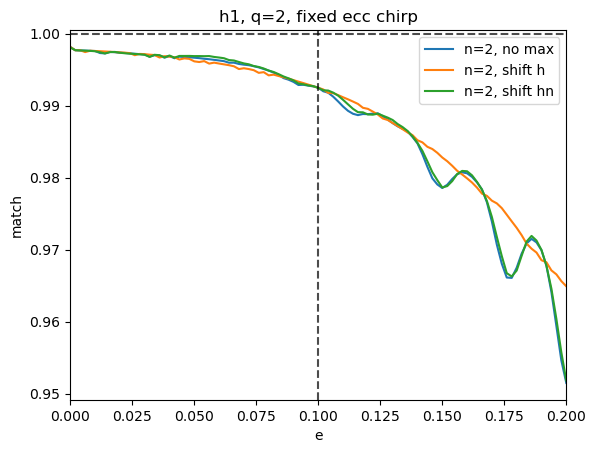

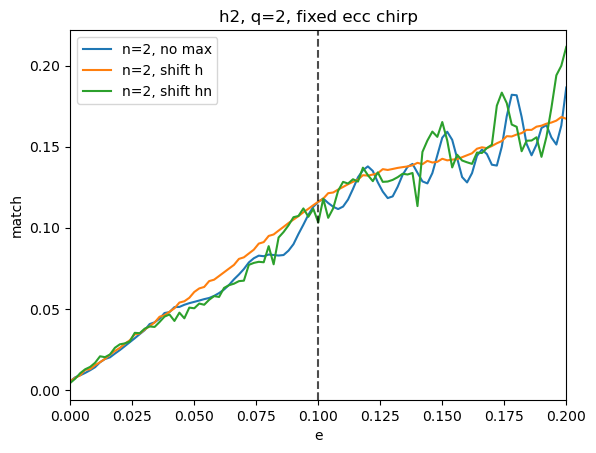

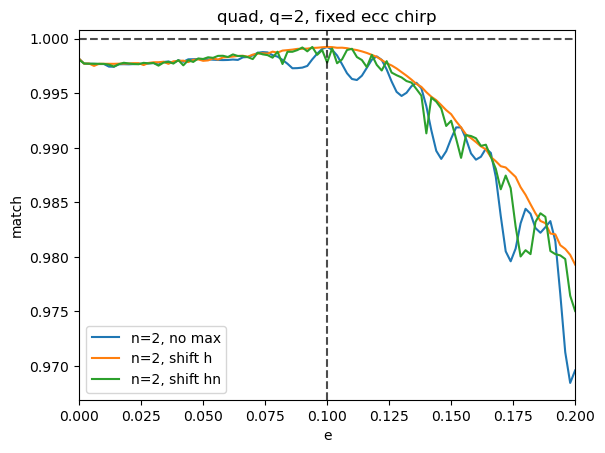

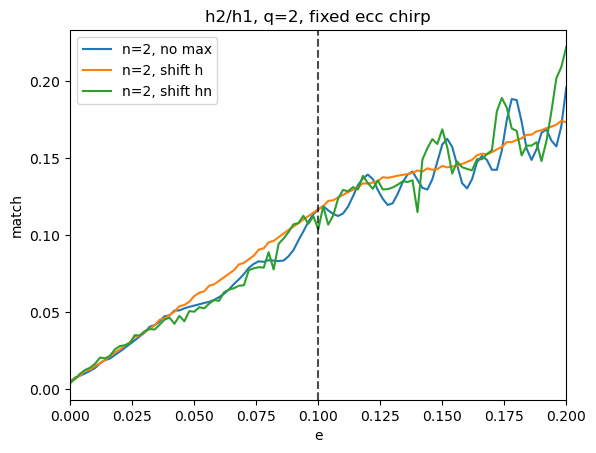

In [31]:
dataslot_8 = load_dataslot(8)
chirp_match_plot(np.linspace(0,0.2,101), 2, 0.1, 24, 2, [dataslot_4, dataslot_6, dataslot_8], ['n=2, no max', 'n=2, shift h', 'n=2, shift hn'], param='ecc_chirp')

## n=4, phase difference, shift hn, against ecc chirp

In [32]:
# start = time.time()
# dataslot_9 = chirp_match_data(np.linspace(0,0.2,101), 4, 0.1, 24, 2, 10, match_method=shift_hn, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_9, 9)

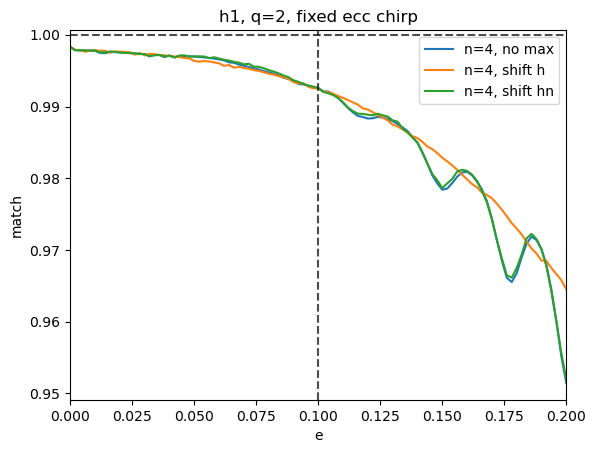

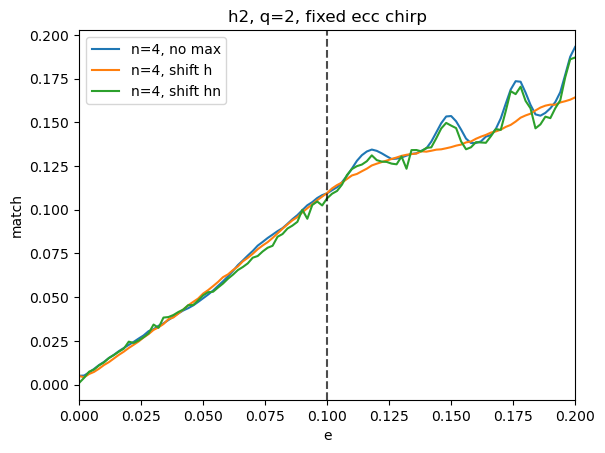

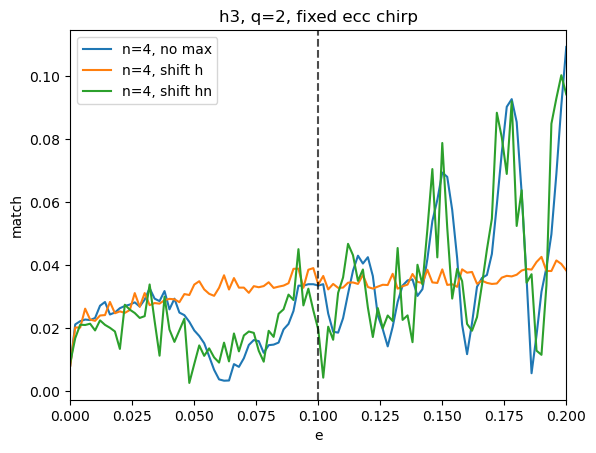

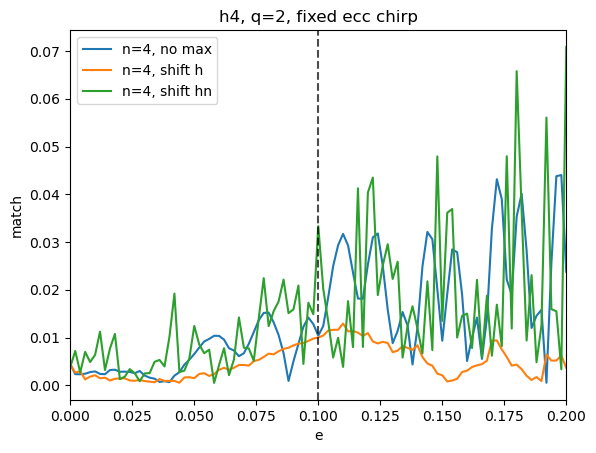

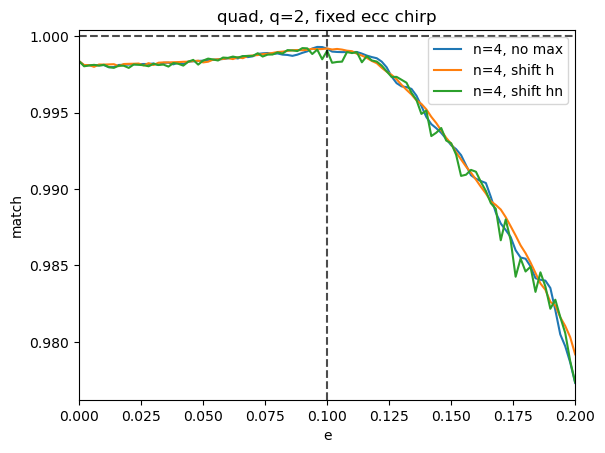

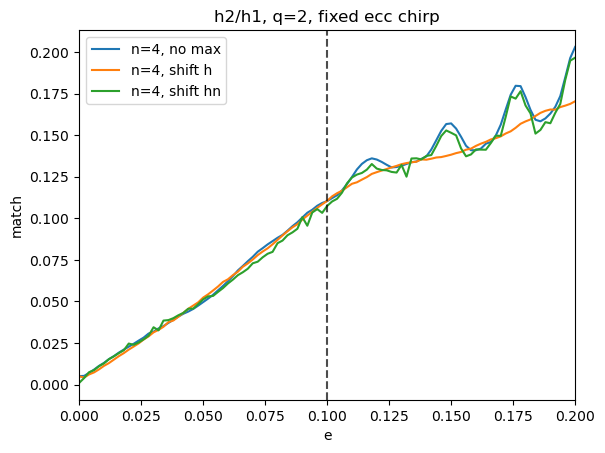

In [33]:
dataslot_9 = load_dataslot(9)
chirp_match_plot(np.linspace(0,0.2,101), 4, 0.1, 24, 2, [dataslot_5, dataslot_7, dataslot_9], ['n=4, no max', 'n=4, shift h', 'n=4, shift hn'], param='ecc_chirp')

## n=2, phase difference, shift h + pi/2, against ecc chirp

In [34]:
# start = time.time()
# dataslot_10 = chirp_match_data(np.linspace(0,0.2,101), 2, 0.1, 24, 2, 10, TA_method=half_pi_TA, match_method=shift_h, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_10, 10)

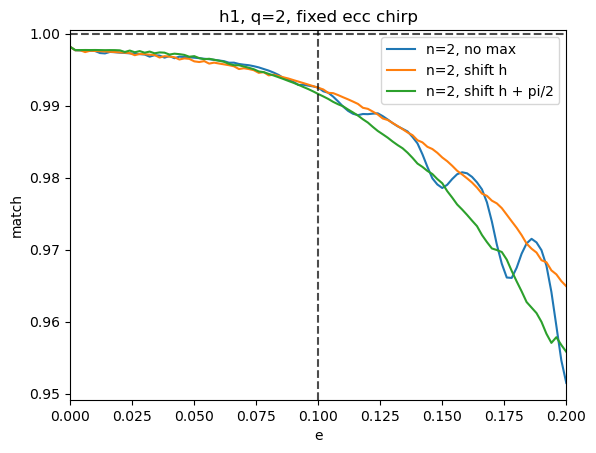

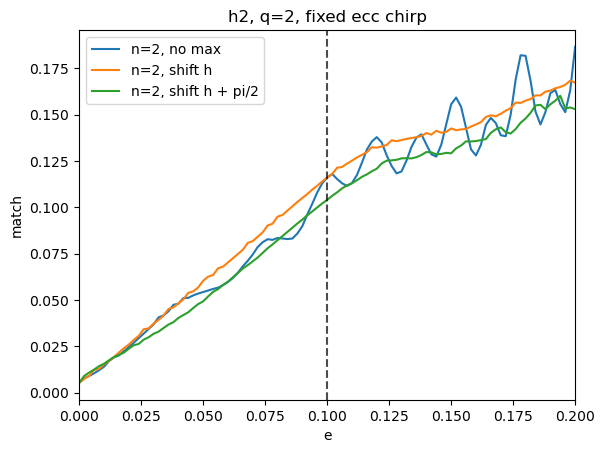

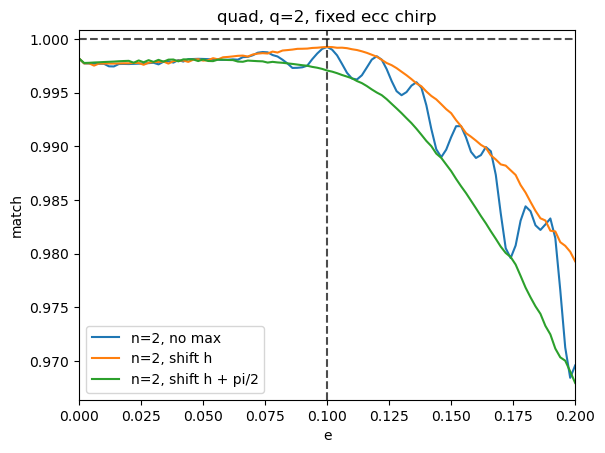

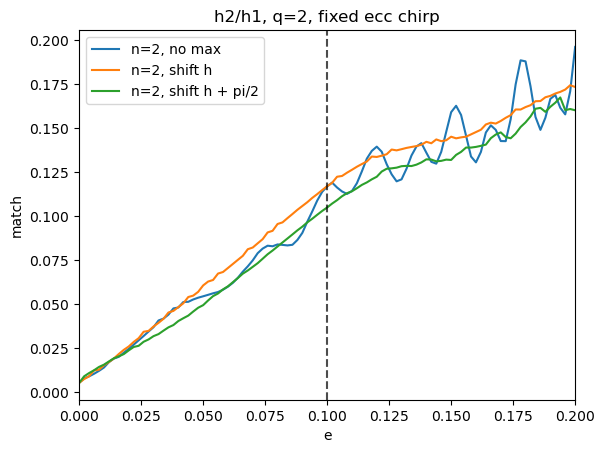

In [35]:
dataslot_10 = load_dataslot(10)
chirp_match_plot(np.linspace(0,0.2,101), 2, 0.1, 24, 2, [dataslot_4, dataslot_6, dataslot_10], ['n=2, no max', 'n=2, shift h', 'n=2, shift h + pi/2'], param='ecc_chirp')

## n=4, phase difference, shift h + pi/2, against ecc chirp

In [36]:
# start = time.time()
# dataslot_11 = chirp_match_data(np.linspace(0,0.2,101), 4, 0.1, 24, 2, 10, TA_method=half_pi_TA, match_method=shift_h, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_11, 11)

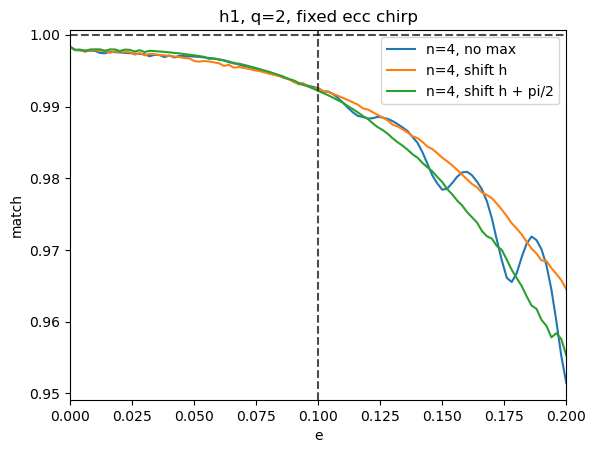

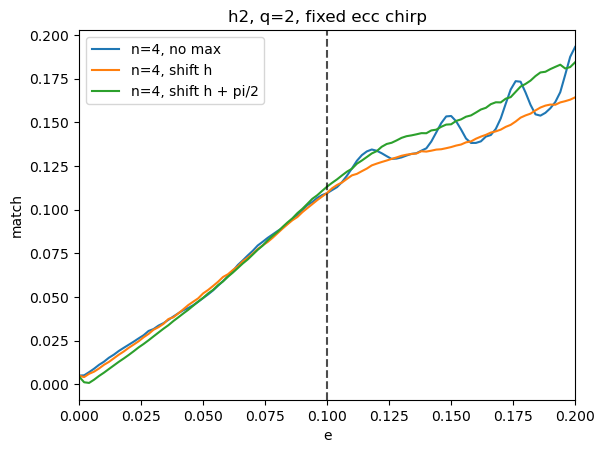

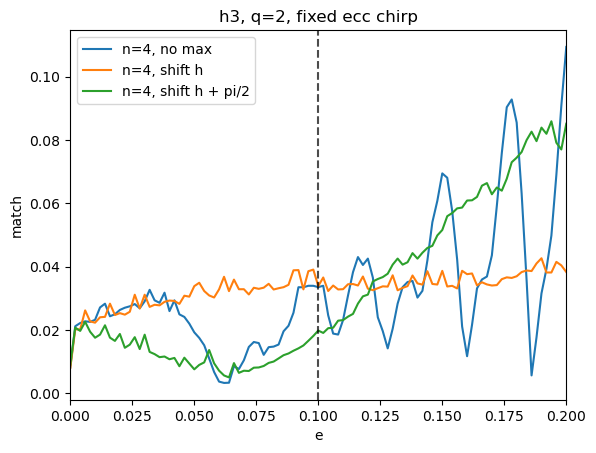

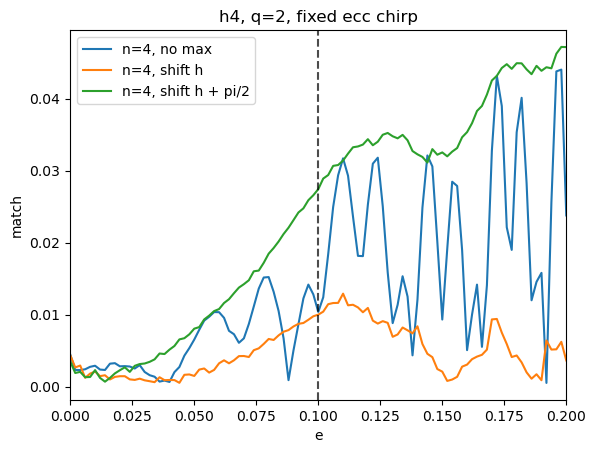

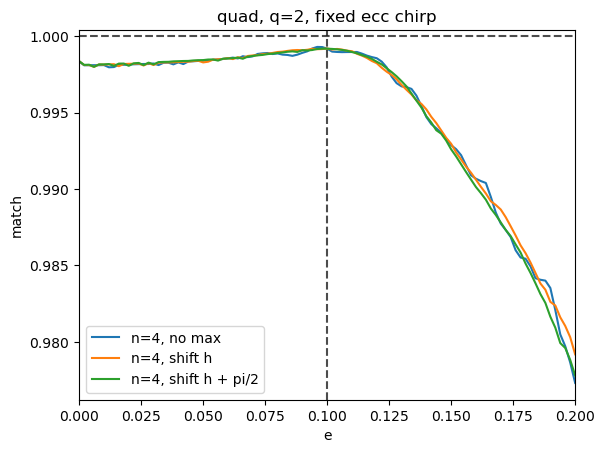

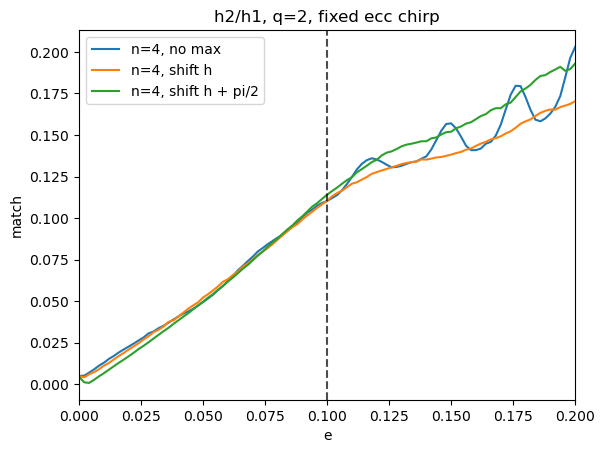

In [37]:
dataslot_11 = load_dataslot(11)
chirp_match_plot(np.linspace(0,0.2,101), 4, 0.1, 24, 2, [dataslot_5, dataslot_7, dataslot_11], ['n=4, no max', 'n=4, shift h', 'n=4, shift h + pi/2'], param='ecc_chirp')

## n=2, phase difference, shift h + sine, against ecc chirp

In [38]:
# start = time.time()
# dataslot_12 = chirp_match_data(np.linspace(0,0.2,101), 2, 0.1, 24, 2, 10, TA_method=get_TA_sine, match_method=shift_h, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_12, 12)

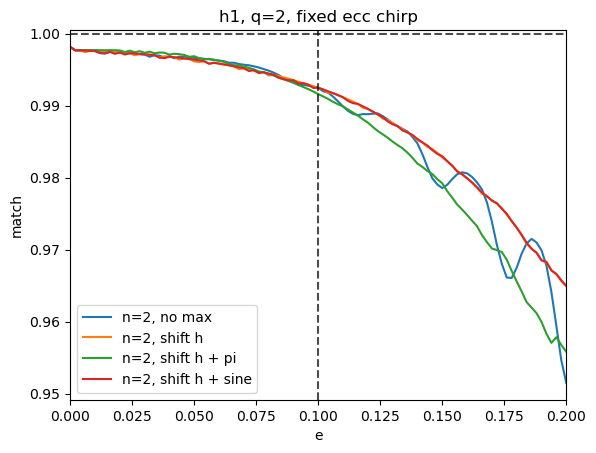

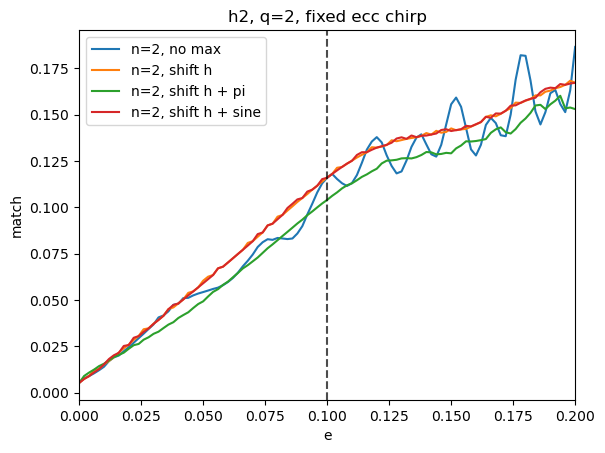

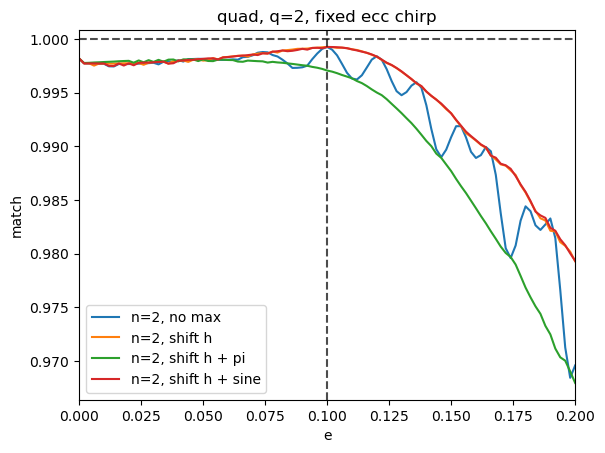

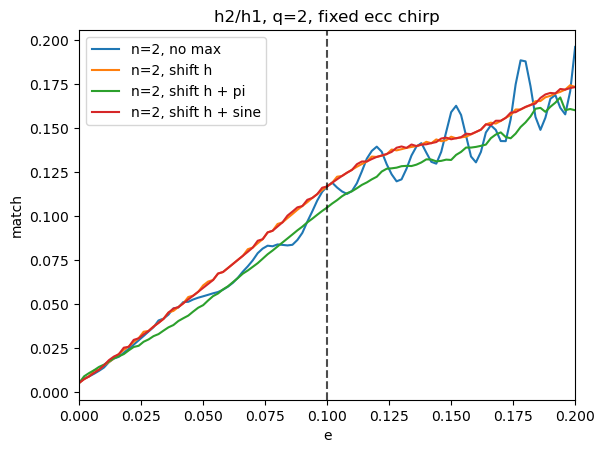

In [39]:
dataslot_12 = load_dataslot(12)
chirp_match_plot(np.linspace(0,0.2,101), 2, 0.1, 24, 2, [dataslot_4, dataslot_6, dataslot_10, dataslot_12], ['n=2, no max', 'n=2, shift h', 'n=2, shift h + pi', 'n=2, shift h + sine'], param='ecc_chirp')

## n=4, phase difference, shift h + sine, against ecc chirp

In [40]:
# start = time.time()
# dataslot_13 = chirp_match_data(np.linspace(0,0.2,101), 4, 0.1, 24, 2, 10, TA_method=get_TA_sine, match_method=shift_h, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_13, 13)

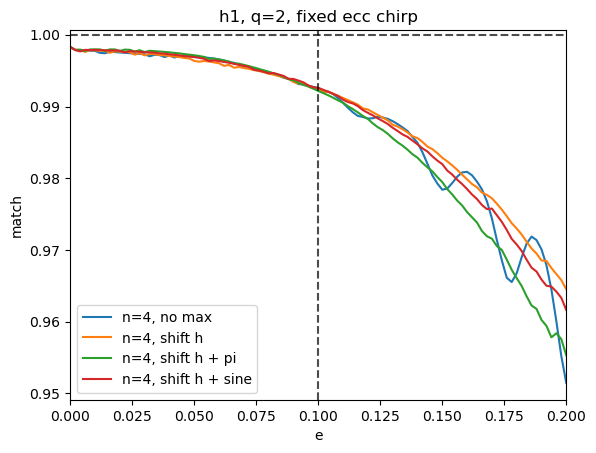

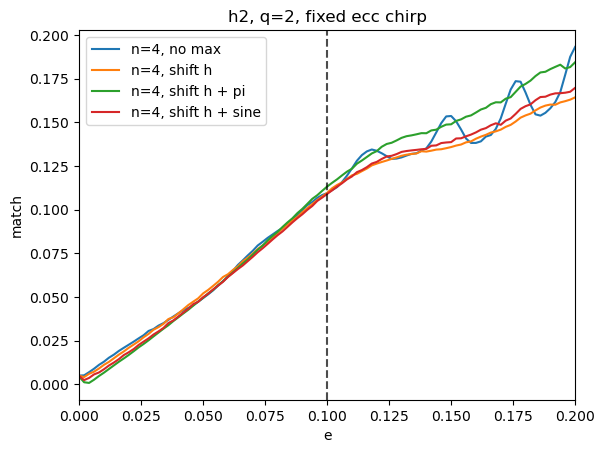

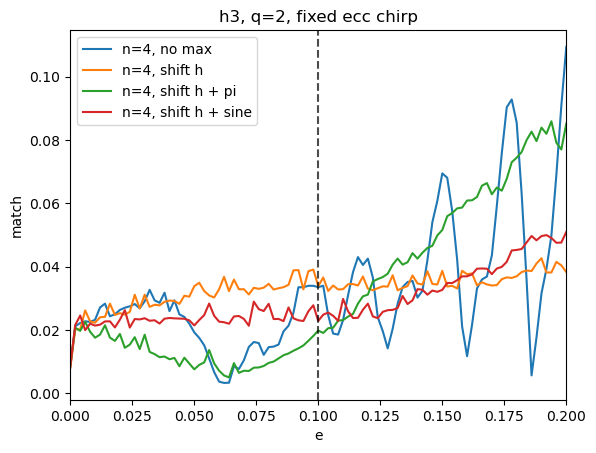

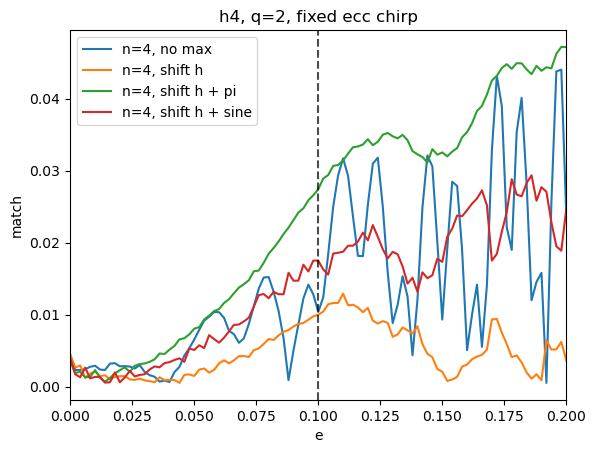

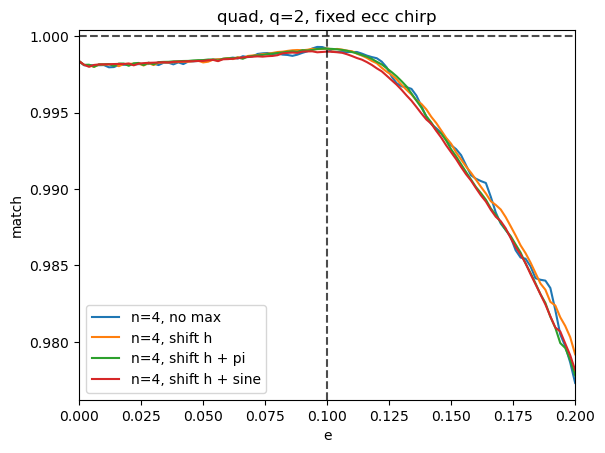

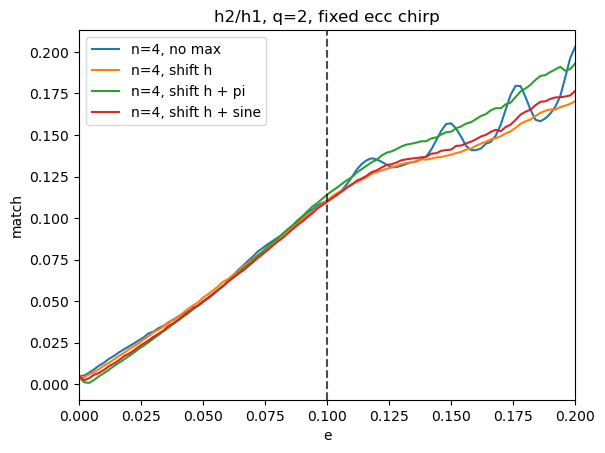

In [41]:
dataslot_13 = load_dataslot(13)
chirp_match_plot(np.linspace(0,0.2,101), 4, 0.1, 24, 2, [dataslot_5, dataslot_7, dataslot_11, dataslot_13], ['n=4, no max', 'n=4, shift h', 'n=4, shift h + pi', 'n=4, shift h + sine'], param='ecc_chirp')

## n=2, shift h, higher e

In [42]:
# start = time.time()
# dataslot_14 = chirp_match_data(np.linspace(0,0.2,101), 2, 0.15, 24, 2, 10, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_14, 14)

# start = time.time()
# dataslot_15 = chirp_match_data(np.linspace(0,0.2,101), 2, 0.15, 24, 2, 10, match_method=shift_h, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_15, 15)

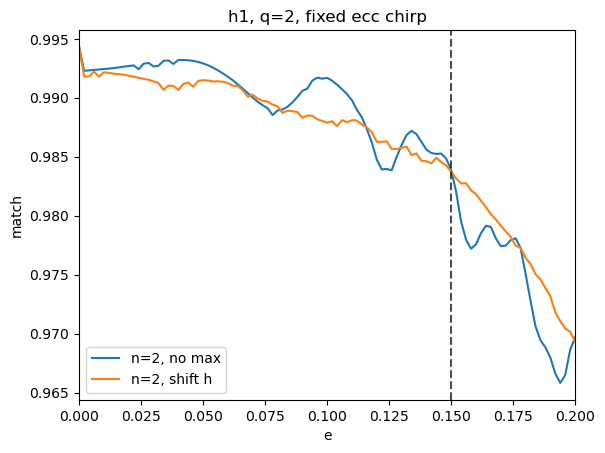

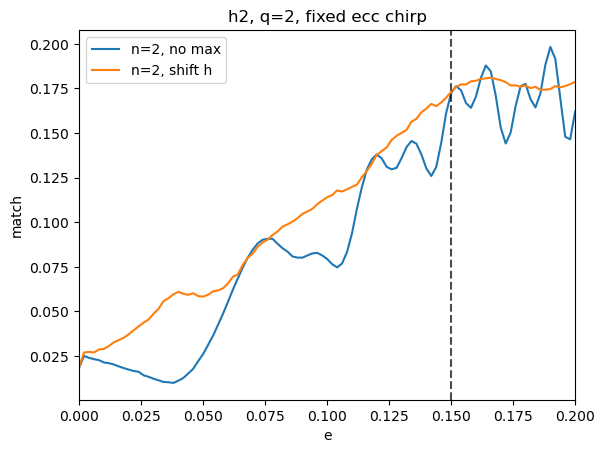

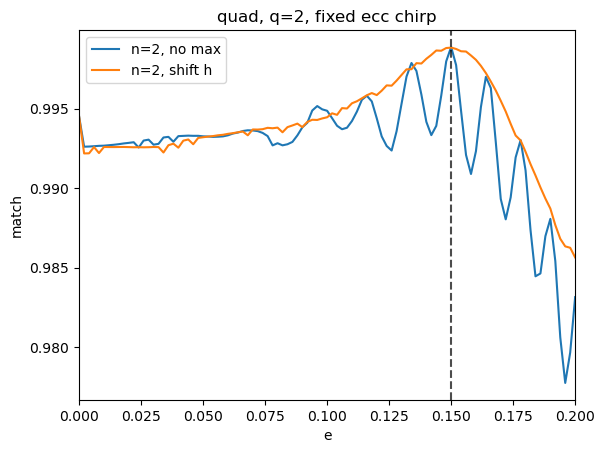

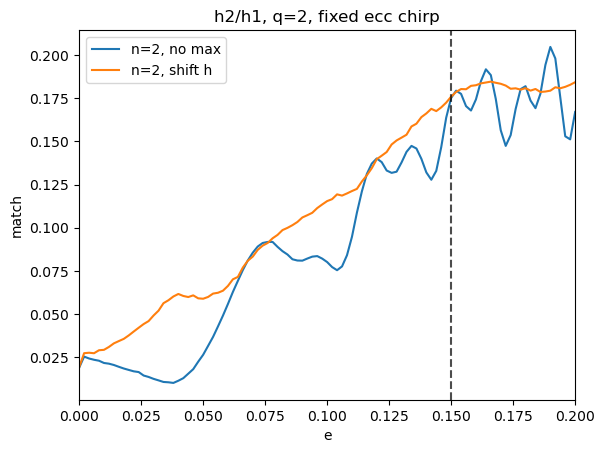

In [43]:
dataslot_14 = load_dataslot(14)
dataslot_15 = load_dataslot(15)
chirp_match_plot(np.linspace(0,0.2,101), 2, 0.15, 24, 2, [dataslot_14, dataslot_15], ['n=2, no max', 'n=2, shift h'], param='ecc_chirp')

## n=4, shift h, higher e

In [44]:
# start = time.time()
# dataslot_16 = chirp_match_data(np.linspace(0,0.2,101), 4, 0.15, 24, 2, 10, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_16, 16)

# start = time.time()
# dataslot_17 = chirp_match_data(np.linspace(0,0.2,101), 4, 0.15, 24, 2, 10, match_method=shift_h, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_17, 17)

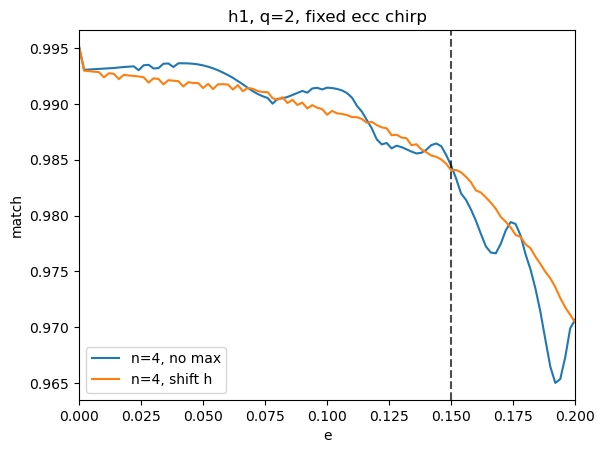

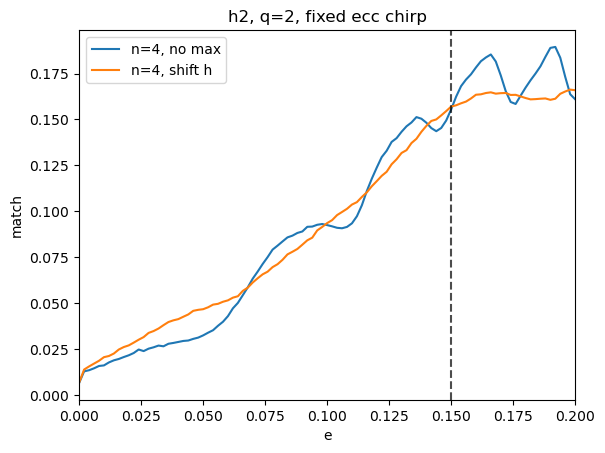

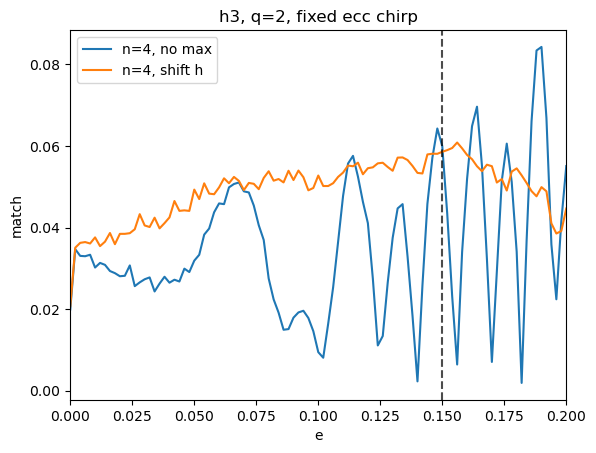

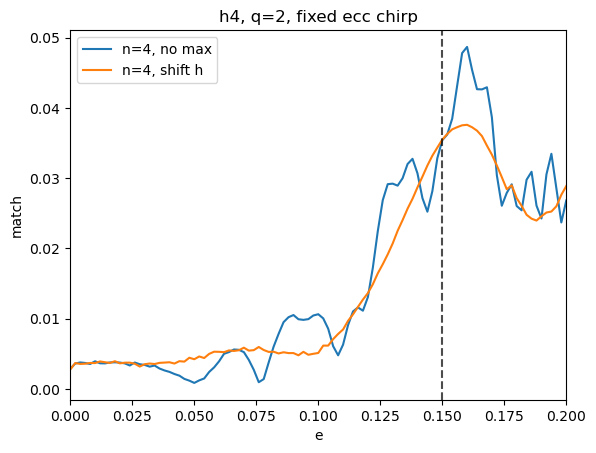

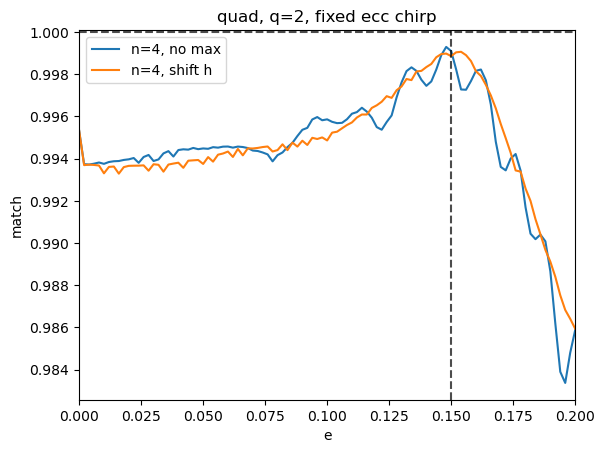

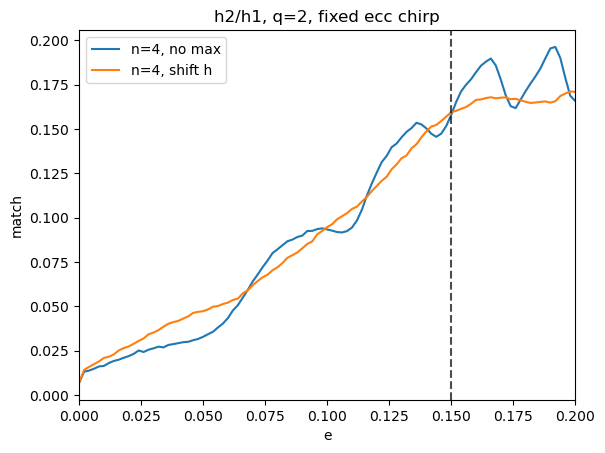

In [45]:
dataslot_16 = load_dataslot(16)
dataslot_17 = load_dataslot(17)
chirp_match_plot(np.linspace(0,0.2,101), 4, 0.15, 24, 2, [dataslot_16, dataslot_17], ['n=4, no max', 'n=4, shift h'], param='ecc_chirp')

## n=6, shift h, higher e

In [46]:
# start = time.time()
# dataslot_22 = chirp_match_data(np.linspace(0,0.2,101), 6, 0.15, 24, 2, 10, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_22, 22)

# start = time.time()
# dataslot_23 = chirp_match_data(np.linspace(0,0.2,101), 6, 0.15, 24, 2, 10, match_method=shift_h, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_23, 23)

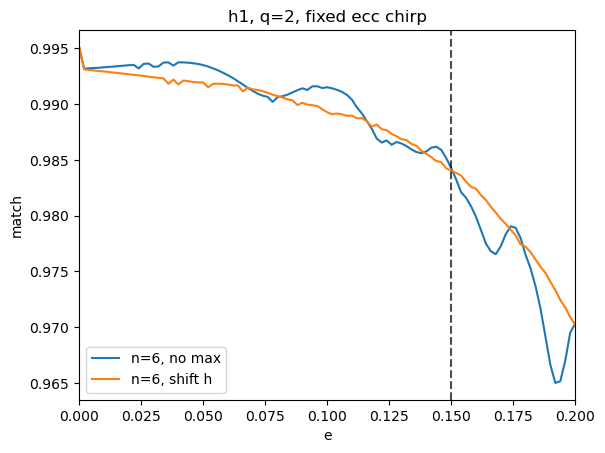

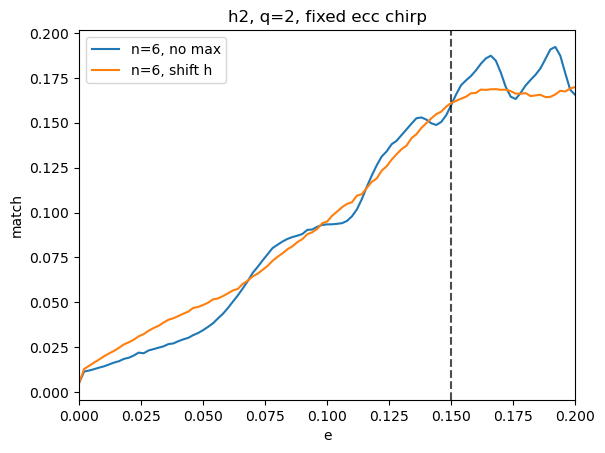

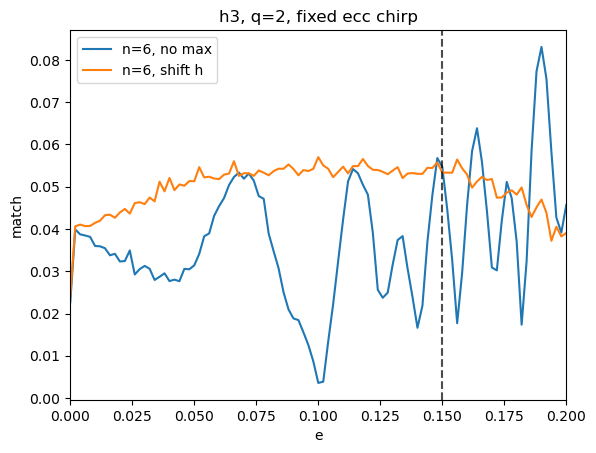

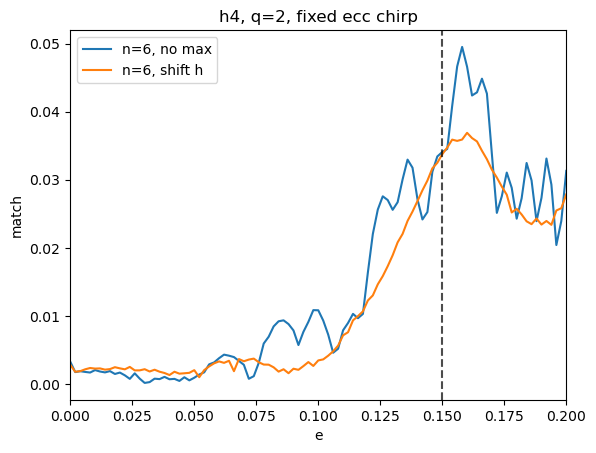

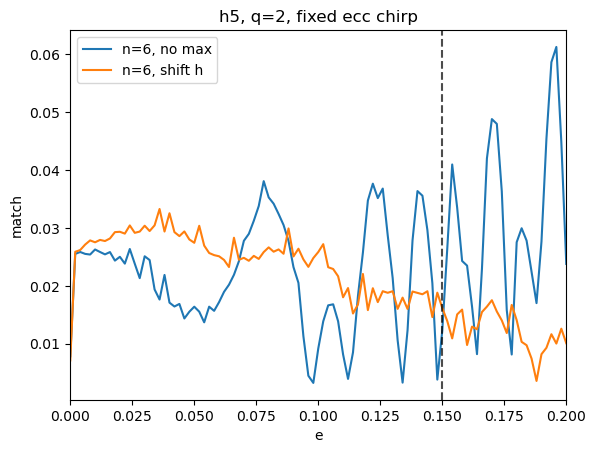

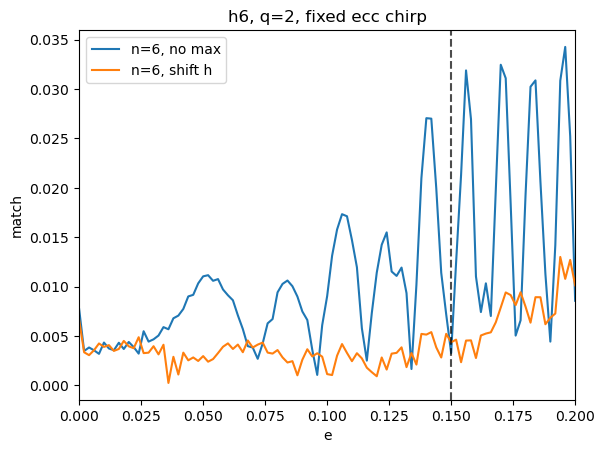

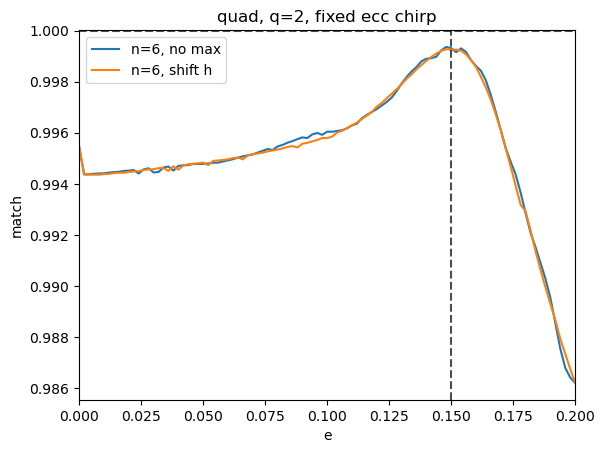

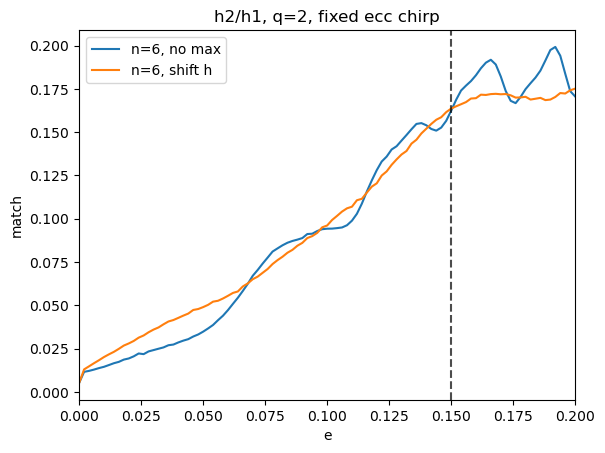

In [47]:
dataslot_22 = load_dataslot(22)
dataslot_23 = load_dataslot(23)
chirp_match_plot(np.linspace(0,0.2,101), 6, 0.15, 24, 2, [dataslot_22, dataslot_23], ['n=6, no max', 'n=6, shift h'], param='ecc_chirp')

## n=2, shift h, lower e

In [48]:
# start = time.time()
# dataslot_18 = chirp_match_data(np.linspace(0,0.2,101), 2, 0.05, 24, 2, 10, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_18, 18)

# start = time.time()
# dataslot_19 = chirp_match_data(np.linspace(0,0.2,101), 2, 0.05, 24, 2, 10, match_method=shift_h, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_19, 19)

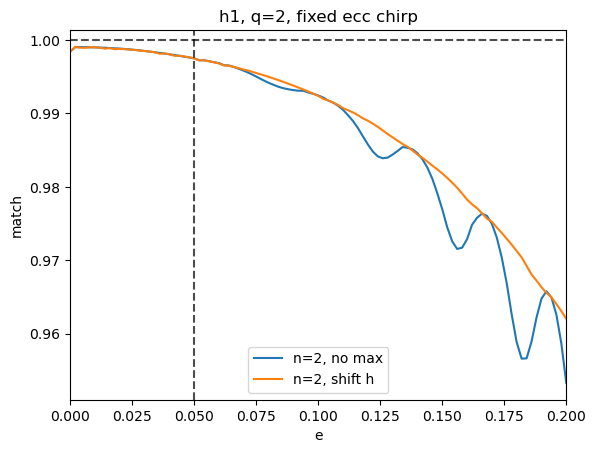

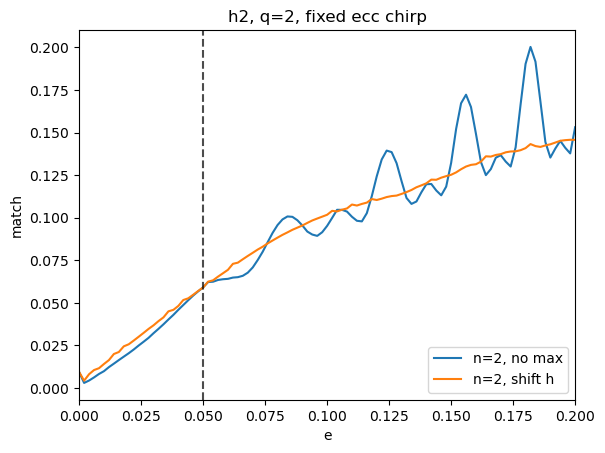

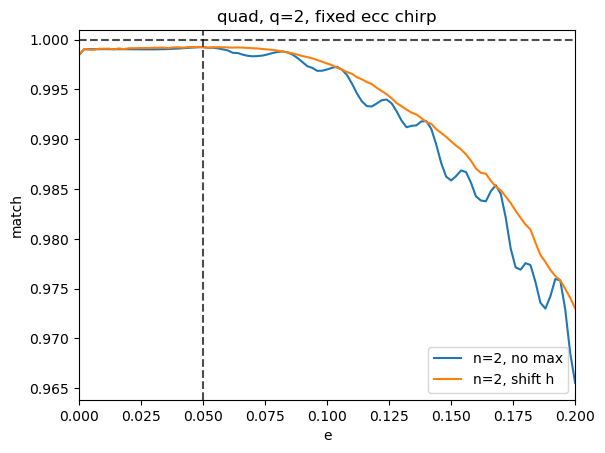

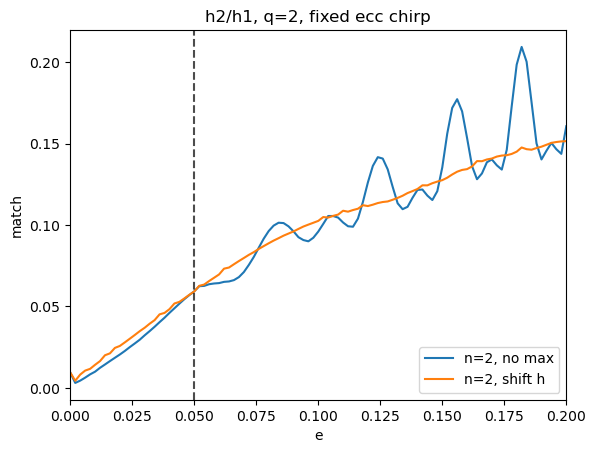

In [49]:
dataslot_18 = load_dataslot(18)
dataslot_19 = load_dataslot(19)
chirp_match_plot(np.linspace(0,0.2,101), 2, 0.05, 24, 2, [dataslot_18, dataslot_19], ['n=2, no max', 'n=2, shift h'], param='ecc_chirp')

## n=4, shift h, lower e

In [50]:
# start = time.time()
# dataslot_20 = chirp_match_data(np.linspace(0,0.2,101), 4, 0.05, 24, 2, 10, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_20, 20)

# start = time.time()
# dataslot_21 = chirp_match_data(np.linspace(0,0.2,101), 4, 0.05, 24, 2, 10, match_method=shift_h, param='ecc_chirp')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_21, 21)

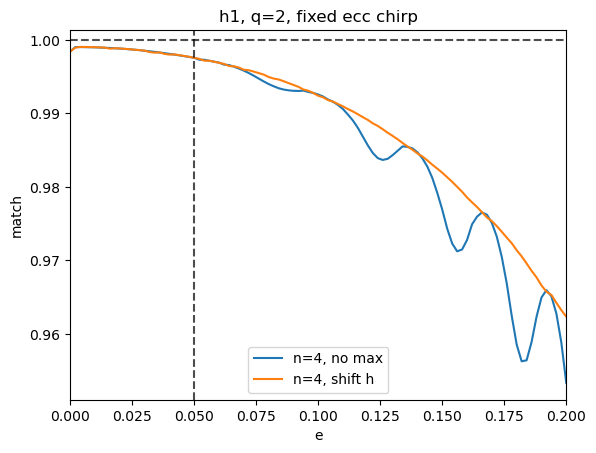

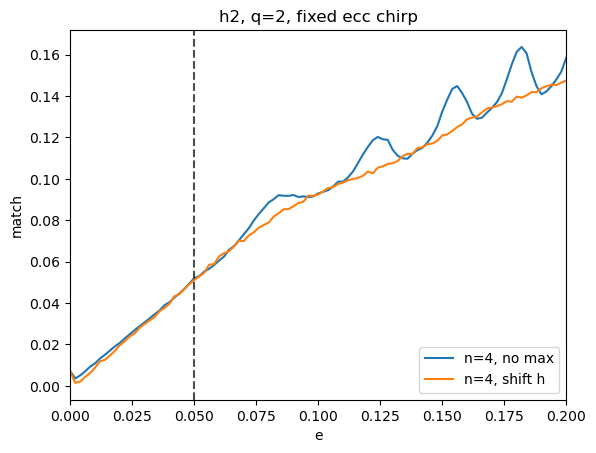

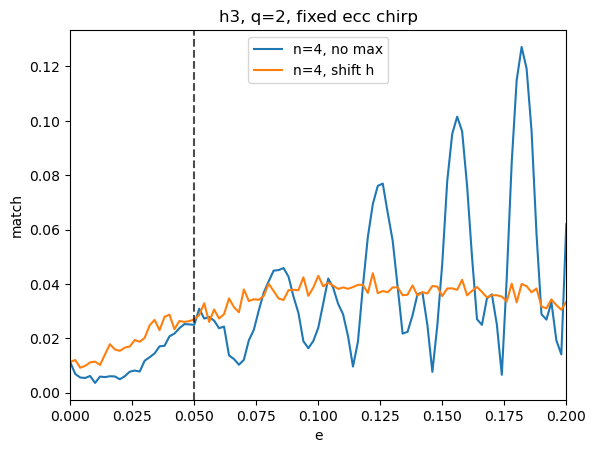

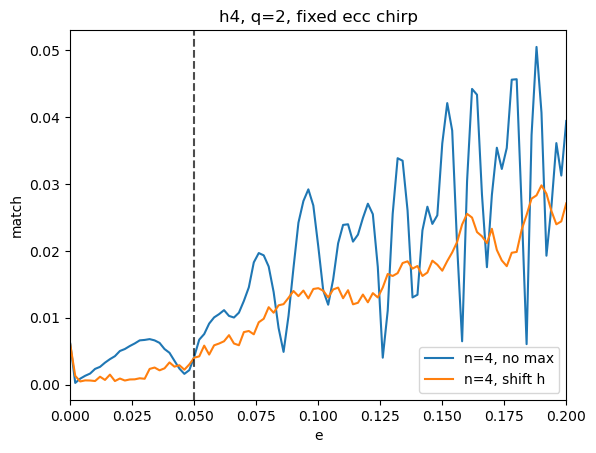

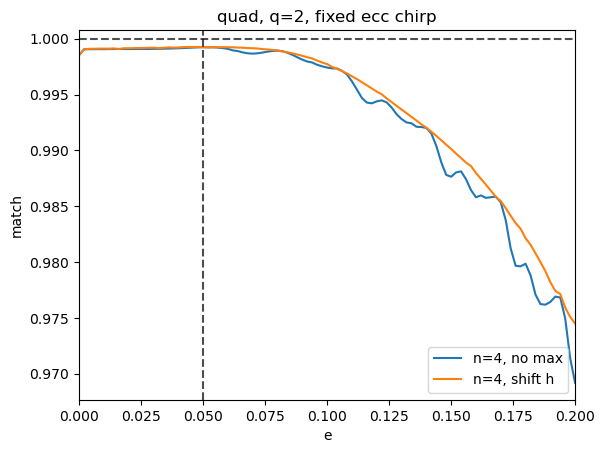

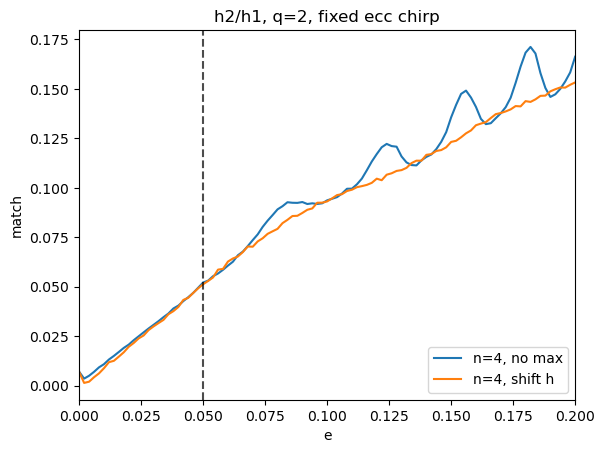

In [51]:
dataslot_20 = load_dataslot(20)
dataslot_21 = load_dataslot(21)
chirp_match_plot(np.linspace(0,0.2,101), 4, 0.05, 24, 2, [dataslot_20, dataslot_21], ['n=4, no max', 'n=4, shift h'], param='ecc_chirp')

# Correction factor

What if instead of shifting true anomaly of s0,s1,...,etc., we were able to use the value of the match and the true anomaly (computed from phase difference) to calculate some kind of corrective factor to get the correct match?

Let's first take the case of h0 in n=4 and compare the values with and without shifting h.

## Exploratory tests

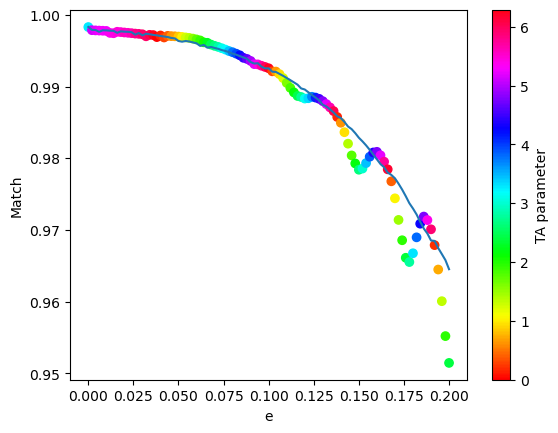

In [52]:
plt.scatter(np.linspace(0,0.2,101), np.array(dataslot_5['h1']), c=-np.array(dataslot_5['diff_phase']), vmin=0, vmax=2*np.pi, cmap='hsv')
plt.plot(np.linspace(0,0.2,101), np.array(dataslot_7['h1']))
plt.xlabel('e')
plt.ylabel('Match')
plt.colorbar(label='TA parameter')

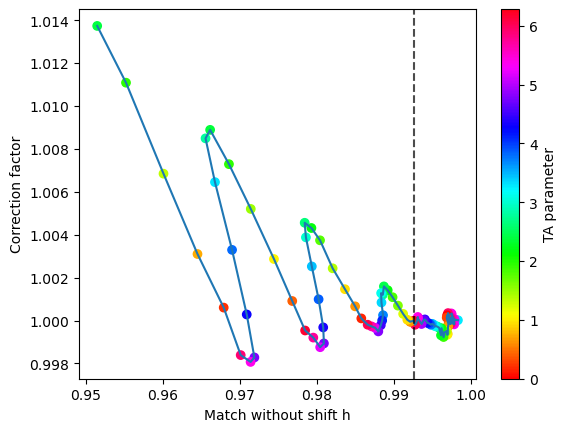

In [53]:
plt.scatter(np.array(dataslot_5['h1']), np.array(dataslot_7['h1'])/np.array(dataslot_5['h1']), c=-np.array(dataslot_5['diff_phase']), vmin=0, vmax=2*np.pi, cmap='hsv')
plt.plot(np.array(dataslot_5['h1']), np.array(dataslot_7['h1'])/np.array(dataslot_5['h1']))
plt.axvline(dataslot_5['h1'][50], c='k', ls='dashed', alpha=0.7)
plt.xlabel('Match without shift h')
plt.ylabel('Correction factor')
plt.colorbar(label='TA parameter')

Seems like combination of TA parameter (from phase diff) and match without shifting h should be sufficient to calculate this factor. Seems like correction factor is something like

$$
1 + k(M_0 - M)(1+\sin{\psi}),
$$

where $M_0$ is the match to a TEOBResumS waveform with same params as fiducial waveform, $M$ is the match to data waveform, $k$ is some constant of proportionality, and $\psi$ is the TA parameter.

Let's try plotting this, and just varying $k$ by hand for now until we get a good fit.

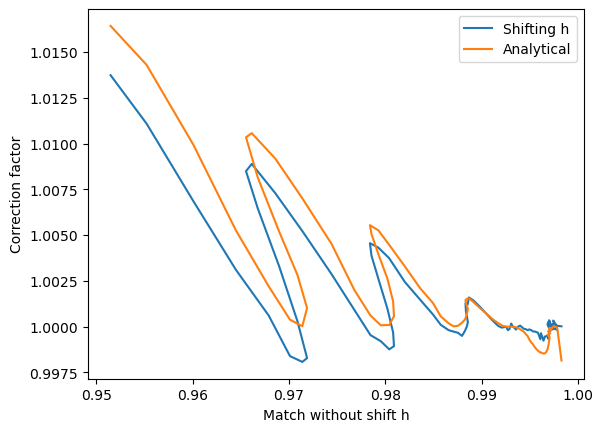

In [153]:
k_0 = 0.2
M_0 = dataslot_5['h1'][50]
y_0 = 1 + (1*k_0+k_0*np.sin(np.array(dataslot_5['diff_phase'])+5*np.pi/4))*(M_0-np.array(dataslot_5['h1']))
plt.plot(np.array(dataslot_5['h1']), np.array(dataslot_7['h1'])/np.array(dataslot_5['h1']), label='Shifting h')
plt.plot(np.array(dataslot_5['h1']), y_0, label='Analytical')
plt.xlabel('Match without shift h')
plt.ylabel('Correction factor')
plt.legend()

Found pretty good fit with $k=0.16$ and $\psi = \mathrm{phase~diff} + 5\pi/4$, although it is clearly not great at match values on the x axis higher than the fiducial params (i.e. the bottom right of above plot).

Can now try using these correction factors to 'correct' match values for h0 without shifting h, and see how it looks.

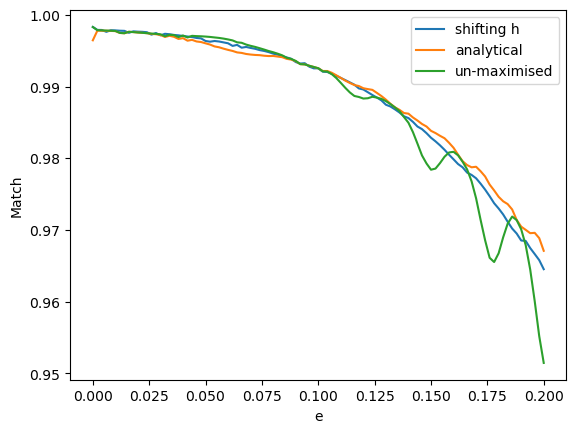

In [154]:
plt.plot(np.linspace(0,0.2,101), np.array(dataslot_7['h1']), label='shifting h')
plt.plot(np.linspace(0,0.2,101), y_0*np.array(dataslot_5['h1']), label='analytical')
plt.plot(np.linspace(0,0.2,101), np.array(dataslot_5['h1']), label='un-maximised')
plt.xlabel('e')
plt.ylabel('Match')
plt.legend()

While clearly not perfect, this is a significant improvement over no maximisation at all. Let's try and repeat now for h1.

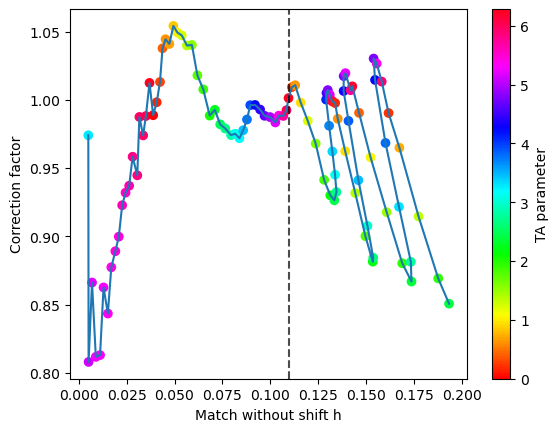

In [56]:
plt.scatter(np.array(dataslot_5['h2']), np.array(dataslot_7['h2'])/np.array(dataslot_5['h2']), c=-np.array(dataslot_5['diff_phase']), vmin=0, vmax=2*np.pi, cmap='hsv')
plt.plot(np.array(dataslot_5['h2']), np.array(dataslot_7['h2'])/np.array(dataslot_5['h2']))
plt.axvline(dataslot_5['h2'][50], c='k', ls='dashed', alpha=0.7)
plt.xlabel('Match without shift h')
plt.ylabel('Correction factor')
plt.colorbar(label='TA parameter')

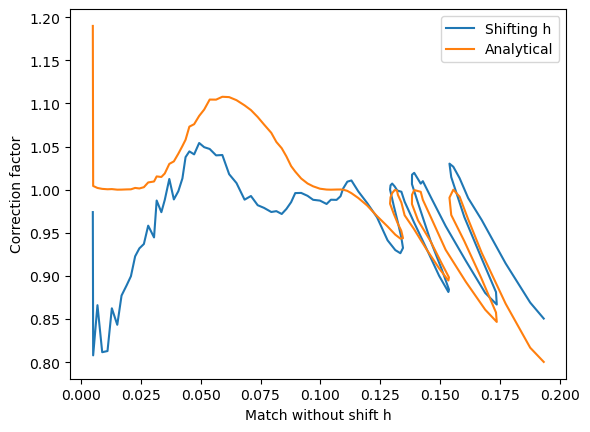

In [177]:
k_1 = 1.2
M_0 = dataslot_5['h2'][50]
y_1 = 1 + (1*k_1+k_1*np.sin(np.array(dataslot_5['diff_phase'])+4.85*np.pi/4))*(M_0-np.array(dataslot_5['h2']))
plt.plot(np.array(dataslot_5['h2']), np.array(dataslot_7['h2'])/np.array(dataslot_5['h2']), label='Shifting h')
plt.plot(np.array(dataslot_5['h2']), y_1, label='Analytical')
plt.xlabel('Match without shift h')
plt.ylabel('Correction factor')
plt.legend()

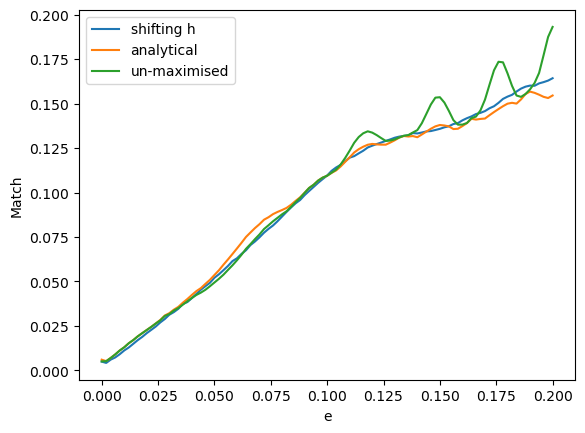

In [178]:
plt.plot(np.linspace(0,0.2,101), np.array(dataslot_7['h2']), label='shifting h')
plt.plot(np.linspace(0,0.2,101), y_1*np.array(dataslot_5['h2']), label='analytical')
plt.plot(np.linspace(0,0.2,101), np.array(dataslot_5['h2']), label='un-maximised')
plt.xlabel('e')
plt.ylabel('Match')
plt.legend()

This also works fairly well. Only change I've made to the equation here is a different value of $k$. $\psi$ has not changed, and I believe should not change (or at least always be the same constant difference from h0) in order to keep quad match, h1/h0 etc. valid.

We can now look at quad match (ignoring h2 and h3) and h1/h0 and see how they have changed with these correction factors.

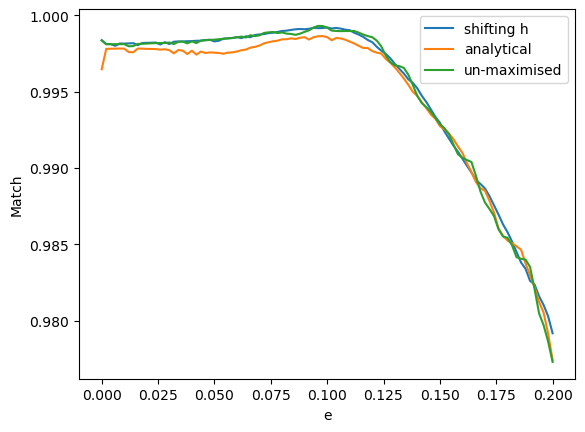

In [160]:
quad = np.sqrt((y_0*dataslot_5['h1'])**2+(y_1*dataslot_5['h2'])**2)
plt.plot(np.linspace(0,0.2,101), np.array(dataslot_7['quad']), label='shifting h')
plt.plot(np.linspace(0,0.2,101), quad, label='analytical')
plt.plot(np.linspace(0,0.2,101), np.array(dataslot_5['quad']), label='un-maximised')
plt.xlabel('e')
plt.ylabel('Match')
plt.legend()

Slightly lower, especially at low e values, which is unsurprising as we have so far ignored h2 and h3. Rest seems fairly similar in terms of wiggly-ness.

Now h1/h0:

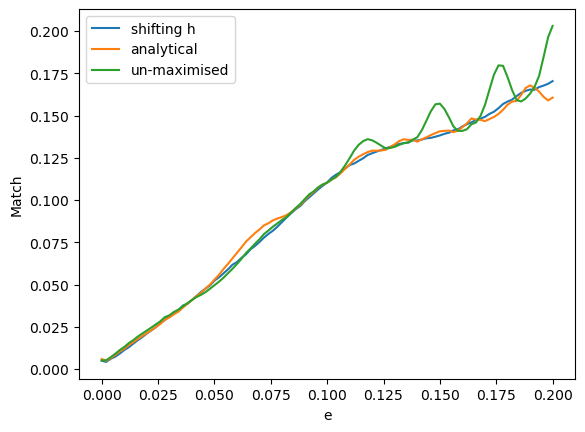

In [60]:
h1_h0 = (y_1*dataslot_5['h2'])/(y_0*dataslot_5['h1'])
plt.plot(np.linspace(0,0.2,101), np.array(dataslot_7['h2'])/np.array(dataslot_7['h1']), label='shifting h')
plt.plot(np.linspace(0,0.2,101), h1_h0, label='analytical')
plt.plot(np.linspace(0,0.2,101), np.array(dataslot_5['h2'])/np.array(dataslot_5['h1']), label='un-maximised')
plt.xlabel('e')
plt.ylabel('Match')
plt.legend()

Again not perfect, but this does seems also improved. So far we have just guessed values for $k$ and $\psi$, so it is possible when calculating them exactly these plots will improve. Also believe there must be improvement to actual equation for values below fiducial eccentricity, as the current one does not match very well for either h0 or h1, and if anything makes the lines slightly worse in this region. For these fiducial eccentricities, we could perhaps get away with not changing the match values here, however we have seen further up that the wiggles here can be significant for higher eccentricities (and potentially other eccentric chirp mass values as well).

This method also relies on being able to find the correct values of $k$ and $\psi$ for each fiducial waveform we use, and accurately enough.

Let's check before proceeding how this method works on values not on the line of degeneracy. We can do this using plots against chirp mass instead of constant eccentric chirp mass.

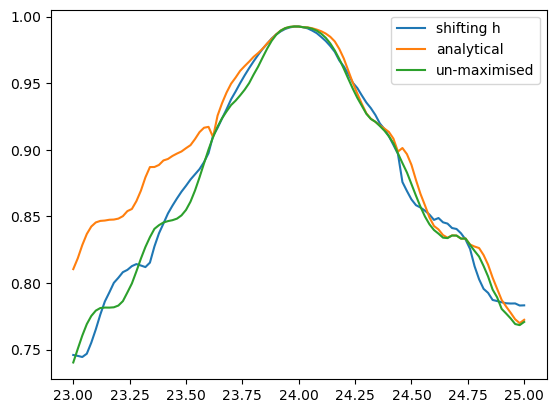

In [61]:
y_chirp_0 = 1 + (k_0+k_0*np.sin(np.array(dataslot_1['diff_phase'])+5*np.pi/4))*(dataslot_1['h1'][50]-np.array(dataslot_1['h1']))
plt.plot(np.linspace(23,25,101), np.array(dataslot_3['h1']), label='shifting h')
plt.plot(np.linspace(23,25,101), y_chirp_0*np.array(dataslot_1['h1']), label='analytical')
plt.plot(np.linspace(23,25,101), np.array(dataslot_1['h1']), label='un-maximised')
plt.legend()

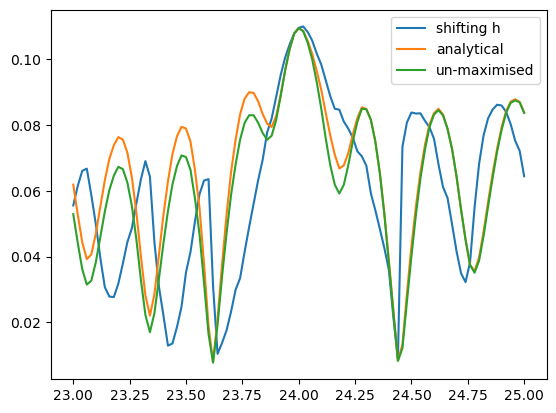

In [62]:
y_chirp_1 = 1 + (k_1+k_1*np.sin(np.array(dataslot_1['diff_phase'])+5*np.pi/4))*(dataslot_1['h2'][50]-np.array(dataslot_1['h2']))
plt.plot(np.linspace(23,25,101), np.array(dataslot_3['h2']), label='shifting h')
plt.plot(np.linspace(23,25,101), y_chirp_1*np.array(dataslot_1['h2']), label='analytical')
plt.plot(np.linspace(23,25,101), np.array(dataslot_1['h2']), label='un-maximised')
plt.legend()

Does not appear to work here. This approach would therefore seem to only work once we have found the correct line of degeneracy, or alternatively our equation requires improvement to be able to handle these regimes.

## Scipy optimisation for coefficients

Let's use scipy optimise to find the best coefficients for these fits, and hope this informs us better how to calculate the coefficients ourselves.

In [138]:
def correction_fit_distance(coeffs, M_0, unmaxed_data, unmaxed_data_phase, shift_h_data):

    # Separate coefficients
    k, alpha, psi = coeffs

    # Get analytical fit and shift h values
    y_analytical = 1 + k*(alpha+np.sin(np.array(unmaxed_data_phase)+psi))*(M_0-np.array(unmaxed_data))
    y_shift_h = np.array(shift_h_data)/np.array(unmaxed_data)

    # Calculate 'distance'
    distance = np.sum(((y_analytical - y_shift_h)*np.array(unmaxed_data))**2)

    return distance

In [139]:
def min_correction_fit_distance(coeff_guesses, M_0, unmaxed_data, unmaxed_data_phase, shift_h_data):

    # Set bounds and arguments of function
    args = [M_0, unmaxed_data, unmaxed_data_phase, shift_h_data]
    bounds = [(None,None),(None,None),(0, 2*np.pi)]

    # Perform maximisation
    max_result = minimize(lambda x: correction_fit_distance(x, *args), coeff_guesses, bounds=bounds)
    max_coeffs = max_result['x']

    # Optimised coefficients
    print(max_coeffs)
    k, alpha, psi = max_coeffs

    # Get analytical fit and shift h values
    y_analytical = 1 + k*(alpha+np.sin(np.array(unmaxed_data_phase)+psi))*(M_0-np.array(unmaxed_data))
    y_shift_h = np.array(shift_h_data)/np.array(unmaxed_data)

    # Plot
    plt.plot(np.array(unmaxed_data), y_shift_h, label='Shifting h')
    plt.plot(np.array(unmaxed_data), y_analytical, label='Analytical')
    plt.xlabel('Match without shift h')
    plt.ylabel('Correction factor')
    plt.legend()
    plt.show()

    # Other plot
    plt.plot(np.linspace(0,0.2,101), np.array(shift_h_data), label='shifting h')
    plt.plot(np.linspace(0,0.2,101), y_analytical*np.array(unmaxed_data), label='analytical')
    plt.plot(np.linspace(0,0.2,101), np.array(unmaxed_data), label='un-maximised')
    plt.xlabel('e')
    plt.ylabel('Match')
    plt.legend()
    plt.show()

    # Other other plot
    plt.plot(np.linspace(0,0.2,101), y_analytical*np.array(unmaxed_data), label='analytical')
    plt.xlabel('e')
    plt.ylabel('Match')
    plt.legend()
    plt.show()

[0.2067115  0.54972827 3.89746837]


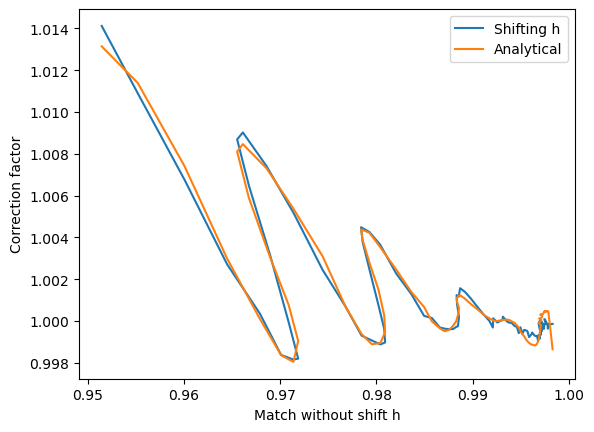

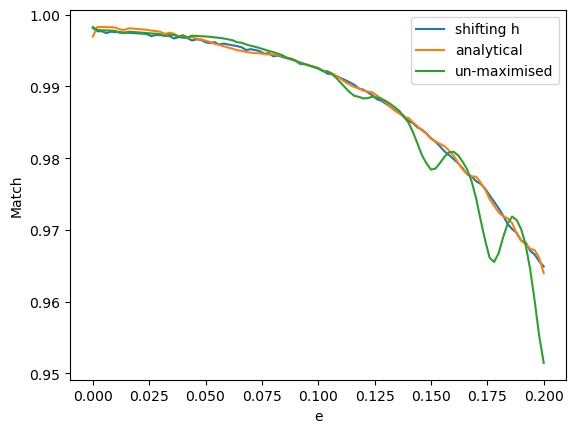

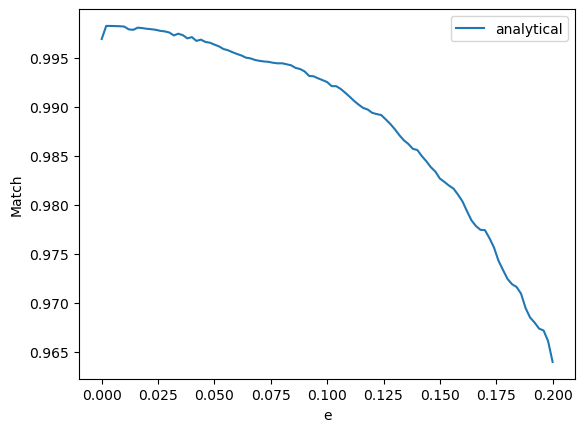

In [140]:
min_correction_fit_distance([0.2,0.5,5*np.pi/4], dataslot_5['h1'][50], dataslot_5['h1'], dataslot_5['diff_phase'], dataslot_6['h1'])

[1.29740355 0.48388406 3.80996188]


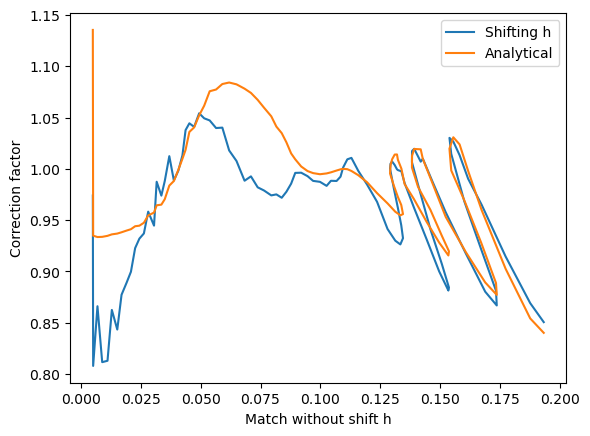

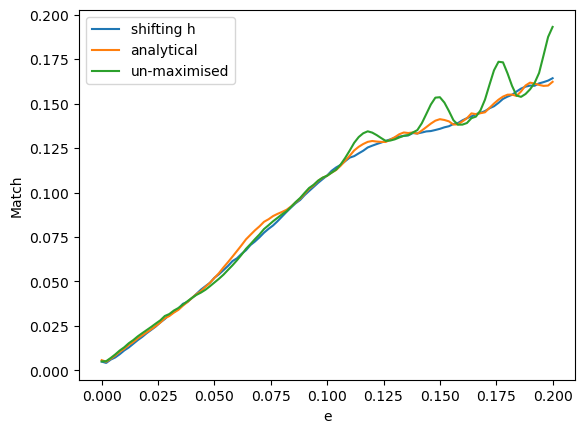

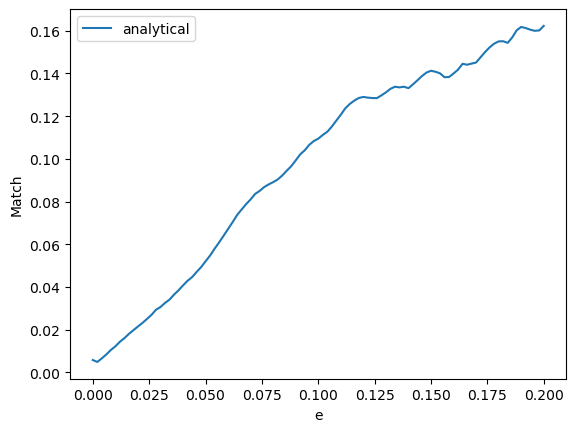

In [130]:
min_correction_fit_distance([1.6,0.5,5*np.pi/4], dataslot_5['h2'][50], dataslot_5['h2'], dataslot_5['diff_phase'], dataslot_7['h2'])

# Plot gridded over MA

In [3]:
def chirp_match_MA_grid_data(param_vals, MA_vals, n, fid_e, fid_M, q, f_low, approximant='TEOBResumS'):

     # Setup match dict and calculate conversion from chirp to total mass
    matches = {'diff_phase':[], 'quad':[]}
    for i in range(n):
            matches[f'h{i+1}'] = []
            matches[f'h{i+1}_phase'] = []

    # Generate fiducial waveform
    all_wfs = list(get_h([1]*n, f_low, fid_e, chirp2total(fid_M, q), q, sample_rate, approximant=approximant))
    wf_hjs = all_wfs[1:n+1]

    # Generate param values
    e_vals = param_vals
    chirp_vals = favata_et_al_avg(fid_e, fid_M, e_vals, f_low=f_low, q=q)

    # Progress bar setup
    progress = 0
    gridsize = len(chirp_vals)*len(MA_vals)
    
    # Loop over chirp mass values
    for e, chirp in zip(e_vals, chirp_vals):
        for i in range(n):
            matches[f'h{i+1}'].append([])
            matches[f'h{i+1}_phase'].append([])
        matches['diff_phase'].append([])
        matches['quad'].append([])

        # Find shifted_e, shifted_f for all MA values
        s_f_2pi = f_low - shifted_f(f_low, e, chirp2total(chirp, q), q)
        s_f_vals = f_low - MA_vals*s_f_2pi/(2*np.pi)
        s_e_vals = shifted_e(s_f_vals, f_low, e)

        # Loop over MA values
        for s_f, s_e in zip(s_f_vals, s_e_vals):
            
            s = gen_wf(s_f, s_e, chirp2total(chirp, q), q, sample_rate, approximant=approximant)
    
            # Calculate matches with chosen method
            match_cplx = match_hn(wf_hjs, s, f_low)
    
            # Save matches
            match_quad_sqrd = 0
            for i in range(n):
                matches[f'h{i+1}'][-1].append(abs(match_cplx[i]))
                matches[f'h{i+1}_phase'][-1].append(np.angle(match_cplx[i]))
                match_quad_sqrd += abs(match_cplx[i])**2
            phase_diff = np.angle(match_cplx[1])-np.angle(match_cplx[0])
            if phase_diff > 0:
                phase_diff -= 2*np.pi
            elif phase_diff < -2*np.pi:
                phase_diff += 2*np.pi
            matches['diff_phase'][-1].append(phase_diff)
            matches['quad'][-1].append(np.sqrt(match_quad_sqrd))

            # Progress bar
            progress += 1
            print('\r' + f'{progress} done out of {gridsize}', end='')

    return matches

In [41]:
def chirp_match_MA_grid_plot(param_vals, MA_vals, n, fid_e, fid_M, q, matches, fixed_MA_lines=[0]):
    
    # Make line plot for each match
    keys = [f'h{i+1}' for i in range(n)]
    keys.append('quad')
    for i, key in enumerate(keys):

        matches[key] = np.array(matches[key])

        # Find min/max over MA
        min_matches = np.min(matches[key], axis=1)
        max_matches = np.max(matches[key], axis=1)

        # Get any fixed MA lines to plot
        fixed_MA_matches = []
        for ind in fixed_MA_lines:
            fixed_MA_matches.append(matches[key][:,ind])

        # Plotting amplitude of matches along degen line
        plt.plot(param_vals, min_matches, label='Min', c='r', ls='dashed', alpha=0.7, zorder=5)
        plt.plot(param_vals, max_matches, label='Max', c='r', ls='dashed', alpha=0.7, zorder=5)
        for fixed_MA_match in fixed_MA_matches:
            plt.plot(param_vals, fixed_MA_match)
        plt.axvline(fid_e, c='k', ls='dashed', zorder=5, alpha=0.7)
        ylim = plt.gca().get_ylim()
        plt.axhline(1, c='k', ls='dashed', zorder=5, alpha=0.7)
        plt.ylim(ylim)
        plt.xlabel('ecc')
        plt.ylabel('match')
        plt.title(f'{key}, q={q}')
        plt.legend()
        plt.xlim(param_vals[0], param_vals[-1])
        plt.show()

    # Repeat for h2/h1
    ratio_matches = matches['h2']/matches['h1']
    
    # Find min/max over MA
    min_matches = np.min(ratio_matches, axis=1)
    max_matches = np.max(ratio_matches, axis=1)

    # Get any fixed MA lines to plot
    fixed_MA_matches = []
    for ind in fixed_MA_lines:
        fixed_MA_matches.append(ratio_matches[:,ind])

    # Plot lines
    plt.plot(param_vals, min_matches, label='Min', c='r', ls='dashed', alpha=0.7, zorder=5)
    plt.plot(param_vals, max_matches, label='Max', c='r', ls='dashed', alpha=0.7, zorder=5)
    for fixed_MA_match in fixed_MA_matches:
        plt.plot(param_vals, fixed_MA_match)
    plt.axvline(fid_e, c='k', ls='dashed', zorder=5, alpha=0.7)
    ylim = plt.gca().get_ylim()
    plt.axhline(1, c='k', ls='dashed', zorder=5, alpha=0.7)
    plt.ylim(ylim)
    plt.xlabel('ecc')
    plt.ylabel('match')
    plt.title(f'h2/h1, q={q}')
    plt.legend()
    plt.xlim(param_vals[0], param_vals[-1])
    plt.show()

In [43]:
# start = time.time()
# dataslot_25 = chirp_match_MA_grid_data(np.linspace(0,0.2,101), np.linspace(0, 2*np.pi, 32, endpoint=False), 4, 0.1, 24, 2, 10, approximant='TEOBResumS')
# end = time.time()
# print(f'\nTime taken: {end-start} seconds.')
# save_dataslot(dataslot_25, 25)

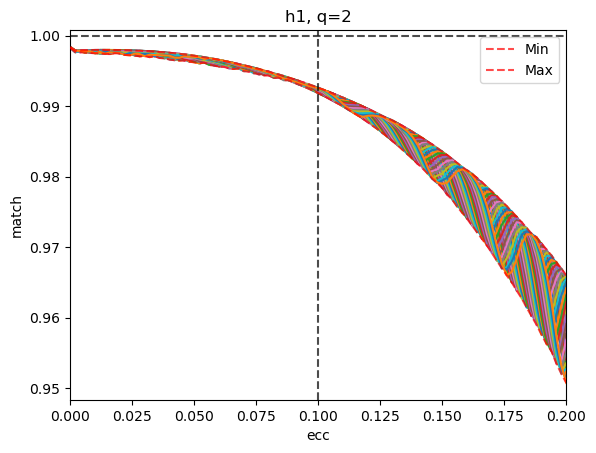

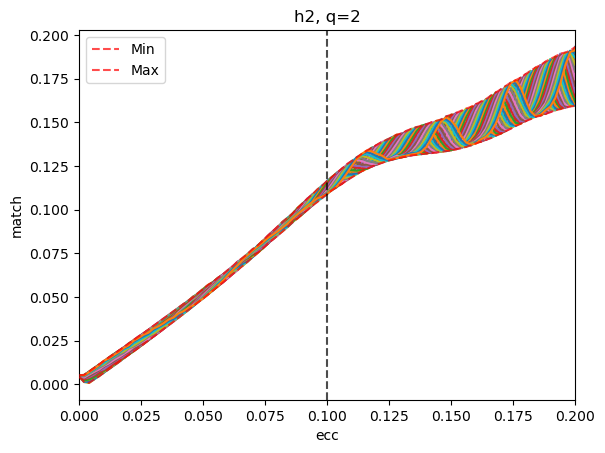

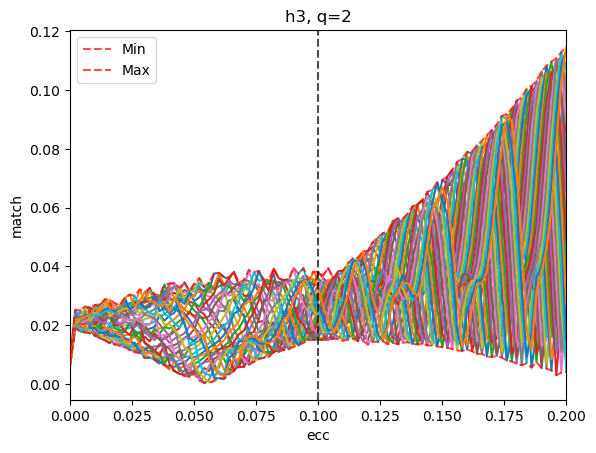

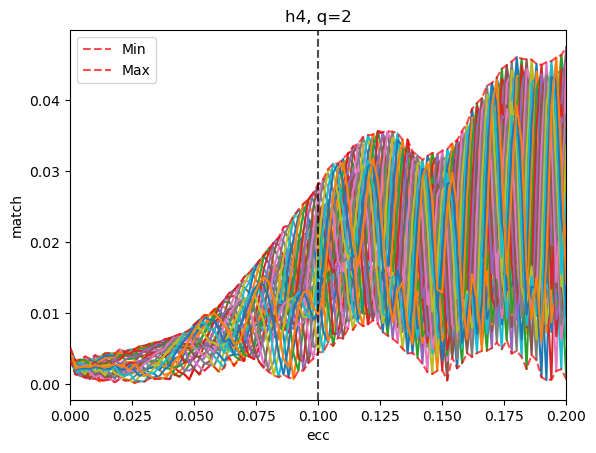

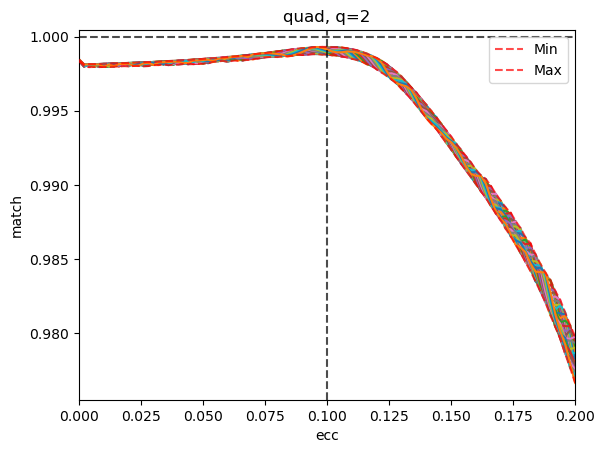

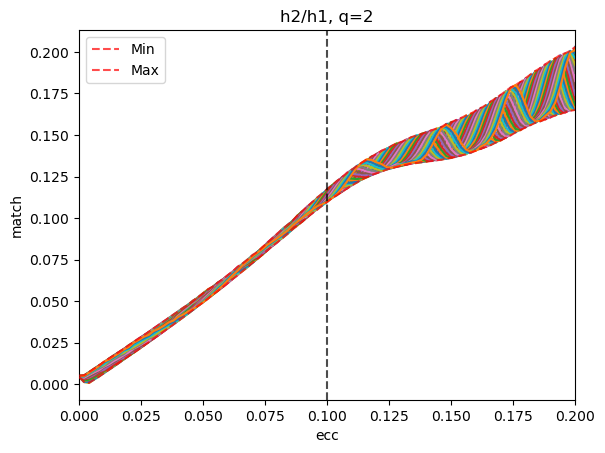

In [42]:
dataslot_25 = load_dataslot(25)
chirp_match_MA_grid_plot(np.linspace(0,0.2,101), np.linspace(0, 2*np.pi, 32, endpoint=False), 4, 0.1, 24, 2, dataslot_25, fixed_MA_lines=np.arange(32))

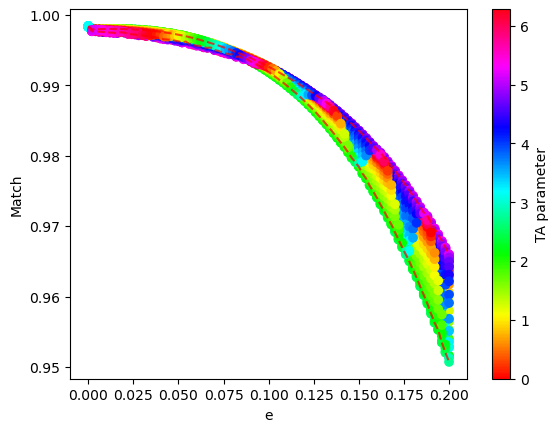

In [119]:
for h1_per_MA, diff_phase_per_MA in zip(np.array(dataslot_25['h1']).T, np.array(dataslot_25['diff_phase']).T):
    plt.scatter(np.linspace(0,0.2,101), h1_per_MA, c=-diff_phase_per_MA, vmin=0, vmax=2*np.pi, cmap='hsv')
plt.plot(np.linspace(0,0.2,101), np.max(np.array(dataslot_25['h1']), axis=1), c='r', ls='dashed', alpha=0.7, zorder=5)
plt.plot(np.linspace(0,0.2,101), np.min(np.array(dataslot_25['h1']), axis=1), c='r', ls='dashed', alpha=0.7, zorder=5)
plt.xlabel('e')
plt.ylabel('Match')
plt.colorbar(label='TA parameter')

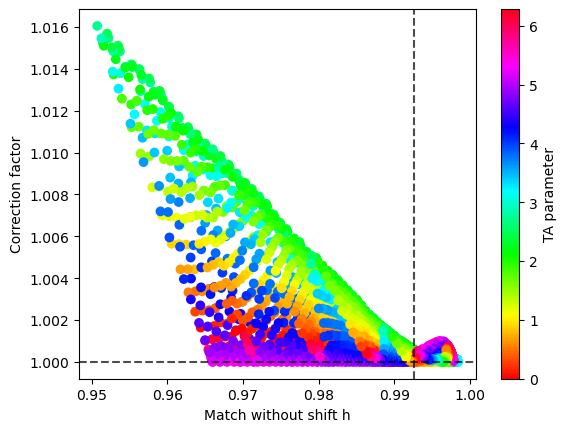

In [99]:
for h1_per_MA, diff_phase_per_MA in zip(np.array(dataslot_25['h1']).T, np.array(dataslot_25['diff_phase']).T):
    plt.scatter(h1_per_MA, np.max(np.array(dataslot_25['h1']), axis=1)/h1_per_MA, c=-diff_phase_per_MA, vmin=0, vmax=2*np.pi, cmap='hsv')
plt.axvline(dataslot_25['h1'][50][0], c='k', ls='dashed', alpha=0.7)
plt.axhline(1, c='k', ls='dashed', alpha=0.7, zorder=5)
plt.xlabel('Match without shift h')
plt.ylabel('Correction factor')
plt.colorbar(label='TA parameter')

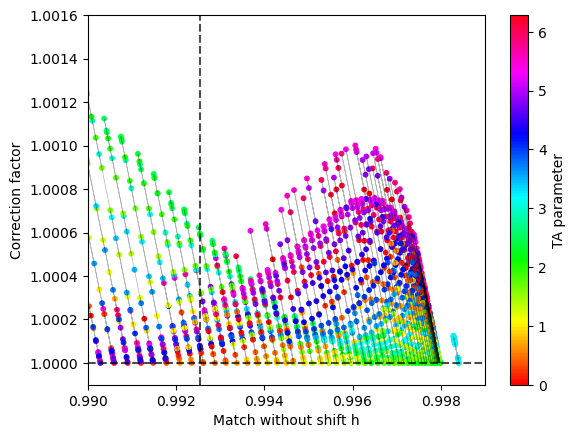

In [132]:
for i, [h1_per_ecc, diff_phase_per_ecc] in enumerate(zip(np.array(dataslot_25['h1']), np.array(dataslot_25['diff_phase']))):
    plt.scatter(h1_per_ecc, np.max(np.array(dataslot_25['h1']), axis=1)[i]/h1_per_ecc, s=10, c=-diff_phase_per_ecc, vmin=0, vmax=2*np.pi, cmap='hsv')
    plt.plot(h1_per_ecc, np.max(np.array(dataslot_25['h1']), axis=1)[i]/h1_per_ecc, c='k', lw=0.5, alpha=0.3)
plt.axvline(dataslot_25['h1'][50][0], c='k', ls='dashed', alpha=0.7)
plt.axhline(1, c='k', ls='dashed', alpha=0.7, zorder=5)
plt.xlim(0.99,0.999)
plt.ylim(0.9999, 1.0016)
plt.xlabel('Match without shift h')
plt.ylabel('Correction factor')
plt.colorbar(label='TA parameter')

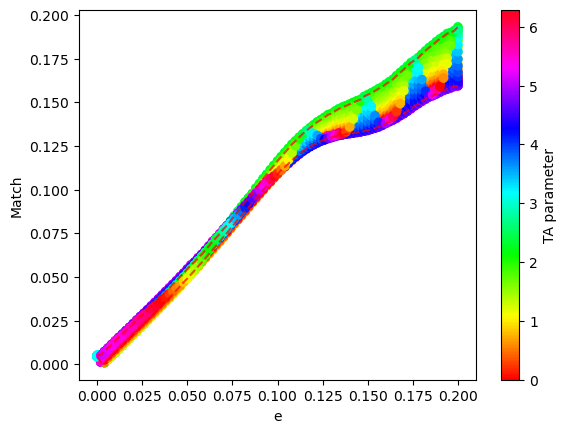

In [88]:
for h2_per_MA, diff_phase_per_MA in zip(np.array(dataslot_25['h2']).T, np.array(dataslot_25['diff_phase']).T):
    plt.scatter(np.linspace(0,0.2,101), h2_per_MA, c=-diff_phase_per_MA, vmin=0, vmax=2*np.pi, cmap='hsv')
plt.plot(np.linspace(0,0.2,101), np.max(np.array(dataslot_25['h2']), axis=1), c='r', ls='dashed', alpha=0.7, zorder=5)
plt.plot(np.linspace(0,0.2,101), np.min(np.array(dataslot_25['h2']), axis=1), c='r', ls='dashed', alpha=0.7, zorder=5)
plt.xlabel('e')
plt.ylabel('Match')
plt.colorbar(label='TA parameter')

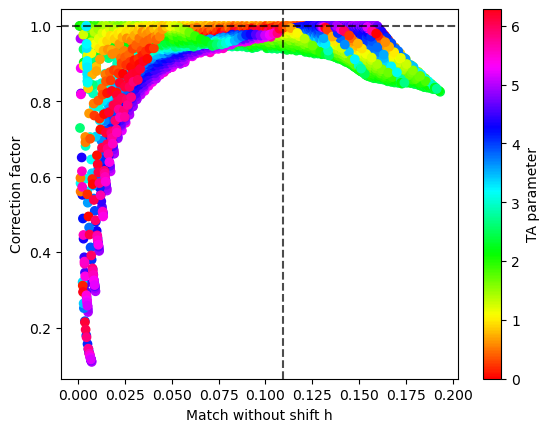

In [75]:
for h2_per_MA, diff_phase_per_MA in zip(np.array(dataslot_25['h2']).T, np.array(dataslot_25['diff_phase']).T):
    plt.scatter(h2_per_MA, np.min(np.array(dataslot_25['h2']), axis=1)/h2_per_MA, c=-diff_phase_per_MA, vmin=0, vmax=2*np.pi, cmap='hsv')
plt.axvline(dataslot_25['h2'][50][0], c='k', ls='dashed', alpha=0.7)
plt.axhline(1, c='k', ls='dashed', alpha=0.7, zorder=5)
plt.xlabel('Match without shift h')
plt.ylabel('Correction factor')
plt.colorbar(label='TA parameter')

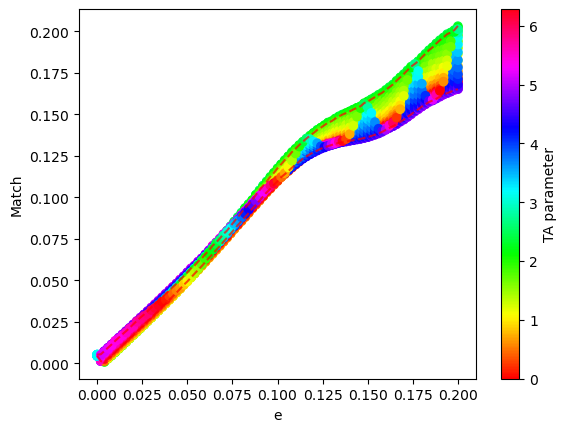

In [78]:
for h1_per_MA, h2_per_MA, diff_phase_per_MA in zip(np.array(dataslot_25['h1']).T, np.array(dataslot_25['h2']).T, np.array(dataslot_25['diff_phase']).T):
    plt.scatter(np.linspace(0,0.2,101), h2_per_MA/h1_per_MA, c=-diff_phase_per_MA, vmin=0, vmax=2*np.pi, cmap='hsv')
plt.plot(np.linspace(0,0.2,101), np.max(np.array(dataslot_25['h2']), axis=1)/np.min(np.array(dataslot_25['h1']), axis=1), c='r', ls='dashed', alpha=0.7, zorder=5)
plt.plot(np.linspace(0,0.2,101), np.min(np.array(dataslot_25['h2']), axis=1)/np.max(np.array(dataslot_25['h1']), axis=1), c='r', ls='dashed', alpha=0.7, zorder=5)
plt.xlabel('e')
plt.ylabel('Match')
plt.colorbar(label='TA parameter')

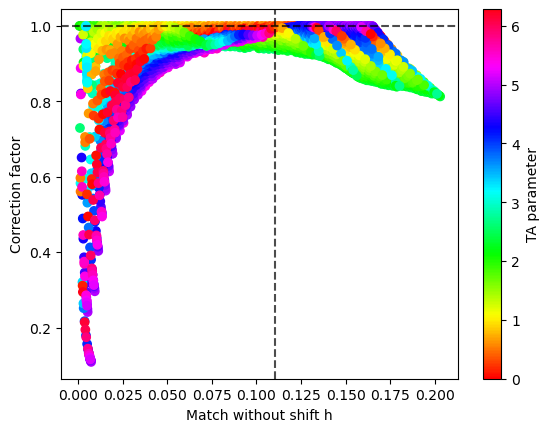

In [80]:
for h1_per_MA, h2_per_MA, diff_phase_per_MA in zip(np.array(dataslot_25['h1']).T, np.array(dataslot_25['h2']).T, np.array(dataslot_25['diff_phase']).T):
    plt.scatter(h2_per_MA/h1_per_MA, np.min(np.array(dataslot_25['h2']), axis=1)*h1_per_MA/(np.max(np.array(dataslot_25['h1']), axis=1)*h2_per_MA), c=-diff_phase_per_MA, vmin=0, vmax=2*np.pi, cmap='hsv')
plt.axvline(dataslot_25['h2'][50][0]/dataslot_25['h1'][50][0], c='k', ls='dashed', alpha=0.7)
plt.axhline(1, c='k', ls='dashed', alpha=0.7, zorder=5)
plt.xlabel('Match without shift h')
plt.ylabel('Correction factor')
plt.colorbar(label='TA parameter')